In [1]:
"""
This script analyses the effect on prediction and data integration
of leaving a batch out of training
"""

# imports
import os
import pandas as pd
import numpy as np
import scvi
import torch
import anndata as ad
from omicsdgd import DGD
import matplotlib.pyplot as plt
import seaborn as sns
import umap
#from sklearn.metrics import silhouette_score

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not suppli

In [2]:
####################
# collect test errors per model and sample
####################
# load data
save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]
train_indices = list(np.where(adata.obs["train_val_test"] == "train")[0])
test_indices = list(np.where(adata.obs["train_val_test"] == "test")[0])
trainset = adata[train_indices, :].copy()
testset = adata[test_indices, :].copy()
batches = trainset.obs["Site"].unique()
test_batches = testset.obs["Site"].values

batches_left_out = ["site1", "site2", "site3", "site4"]
model_names = [
    "human_bonemarrow_l20_h2-3_leftout_site1",
    "human_bonemarrow_l20_h2-3_leftout_site2",
    "human_bonemarrow_l20_h2-3_leftout_site3",
    "human_bonemarrow_l20_h2-3_leftout_site4",
]

### plots for the original model

In [3]:
# plot the test latent space of the original moel trained on all sites
model_name = "human_bonemarrow_l20_h2-3_test50e"

model = DGD.load(
    data=trainset,
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [4]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

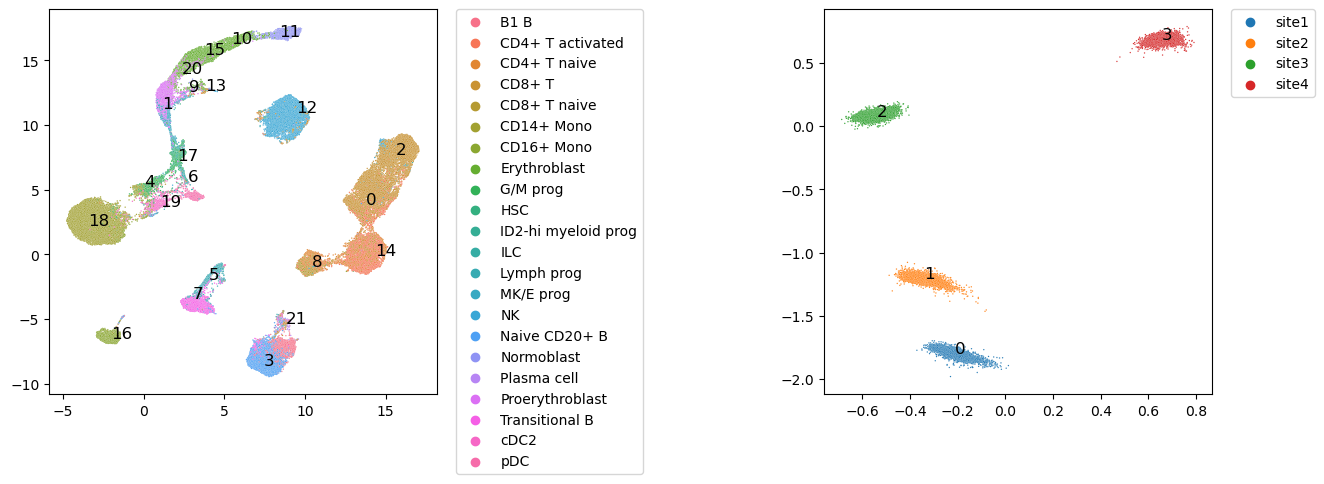

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=trainset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_rep.z.detach().cpu().numpy()[:, 1],
    hue=trainset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [6]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

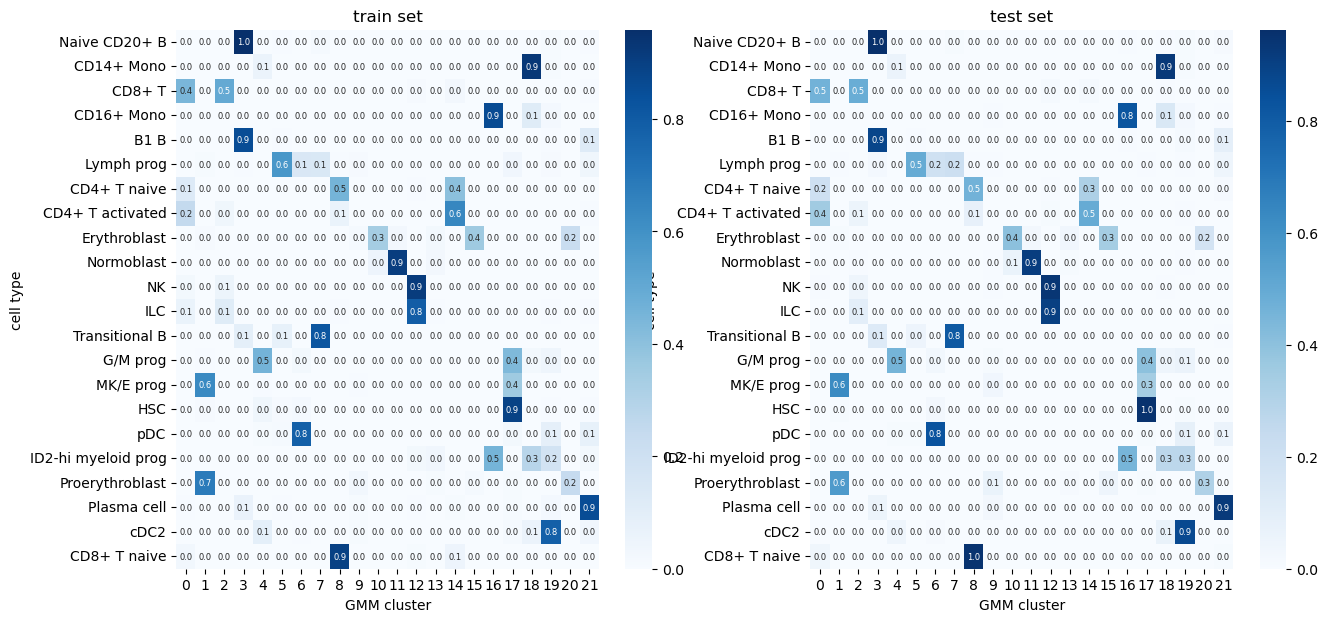

In [7]:
# make a confusion matrix showing the fraction of cells in each cluster
# first for cell types and gmm clusters for train and test sets
# second for sites and correction_gmm clusters

# for cell types
# first make the confusion matrix
celltypes = trainset.obs["cell_type"].unique()
confusion_matrix = np.zeros((len(celltypes), model.gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(celltypes), model.gmm.n_mix_comp))
for i, celltype in enumerate(celltypes):
    # get the indices of the trainset that are of this celltype
    celltype_indices = np.where(trainset.obs["cell_type"].values == celltype)[0]
    celltype_indices_test = np.where(testset.obs["cell_type"].values == celltype)[0]
    # get the clusters that these indices are in
    clusters = train_basal_clusters[celltype_indices].cpu().numpy()
    clusters_test = test_basal_clusters[celltype_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(celltype_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(celltype_indices_test)
# normalize the confusion matrix
#confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=0)
#confusion_matrix_test = confusion_matrix_test / np.sum(confusion_matrix_test, axis=0)
# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("cell type")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("cell type")
ax[1].set_title("test set")
plt.show()

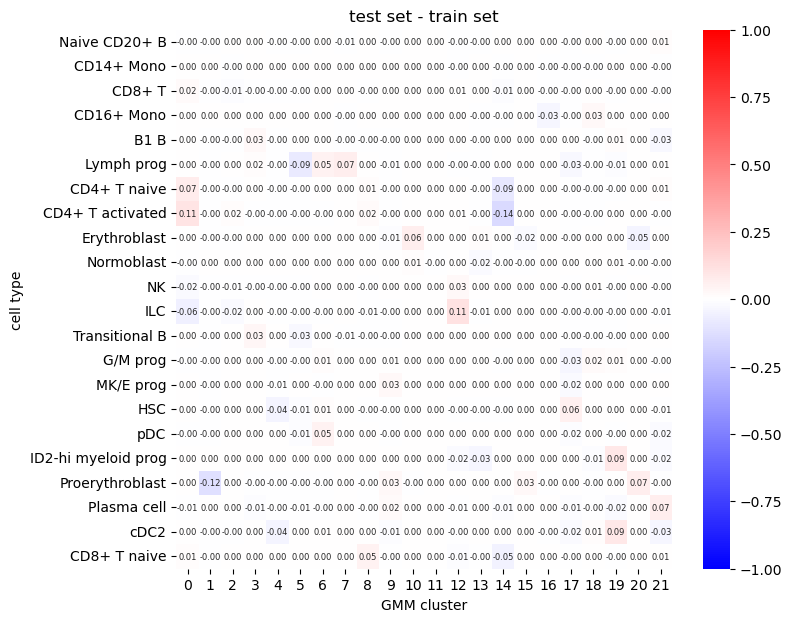

In [10]:
# now plot a heatmap of the difference
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(
    confusion_matrix_test - confusion_matrix,
    cmap="bwr",
    annot=True,
    xticklabels=np.arange(model.gmm.n_mix_comp),
    yticklabels=celltypes,
    fmt=".2f",
    ax=ax,
    annot_kws={"fontsize": 6},
    vmin=-1,
    vmax=1,
)
ax.set_xlabel("GMM cluster")
ax.set_ylabel("cell type")
ax.set_title("test set - train set")
plt.show()

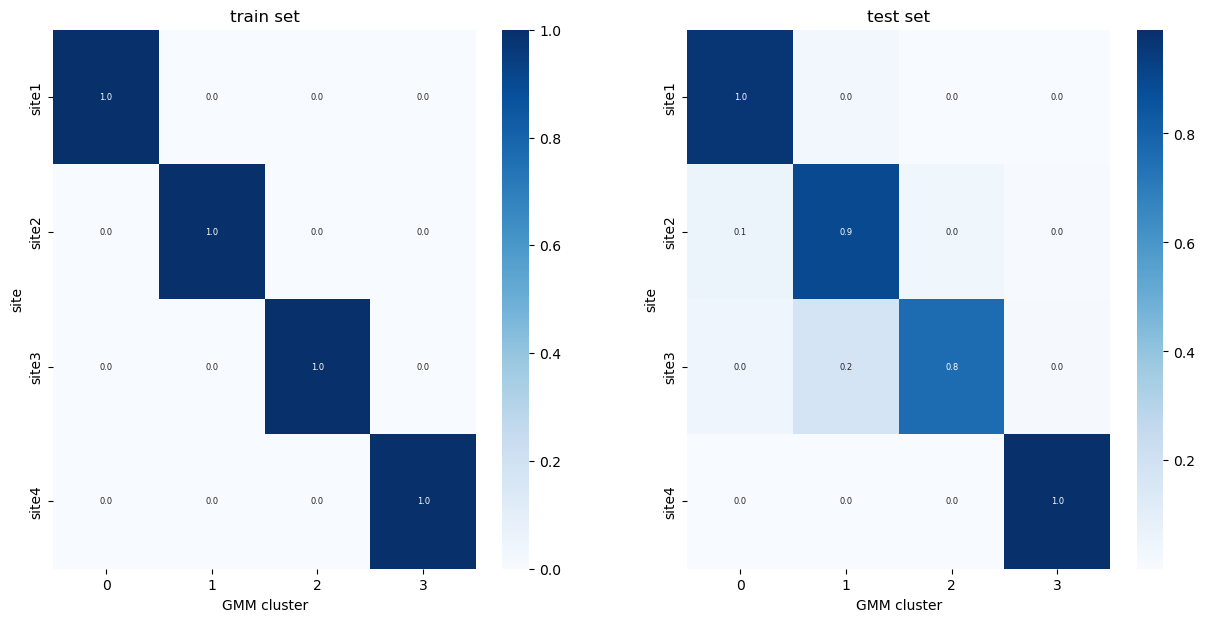

In [8]:
# same for covariates

sites = trainset.obs["Site"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset.obs["Site"].values == site)[0]
    site_indices_test = np.where(testset.obs["Site"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

In [5]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

# put the reps in a dataframe so I can randomize the order
plot_df = pd.DataFrame(
    {
        "UMAP D1": rep[:, 0],
        "UMAP D2": rep[:, 1],
        "celltype": testset.obs["cell_type"].values,
        "site D1": model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
        "site D2": model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
        "site": testset.obs["Site"].values
    }
)
# randomize the order
plot_df = plot_df.sample(frac=1)

testset


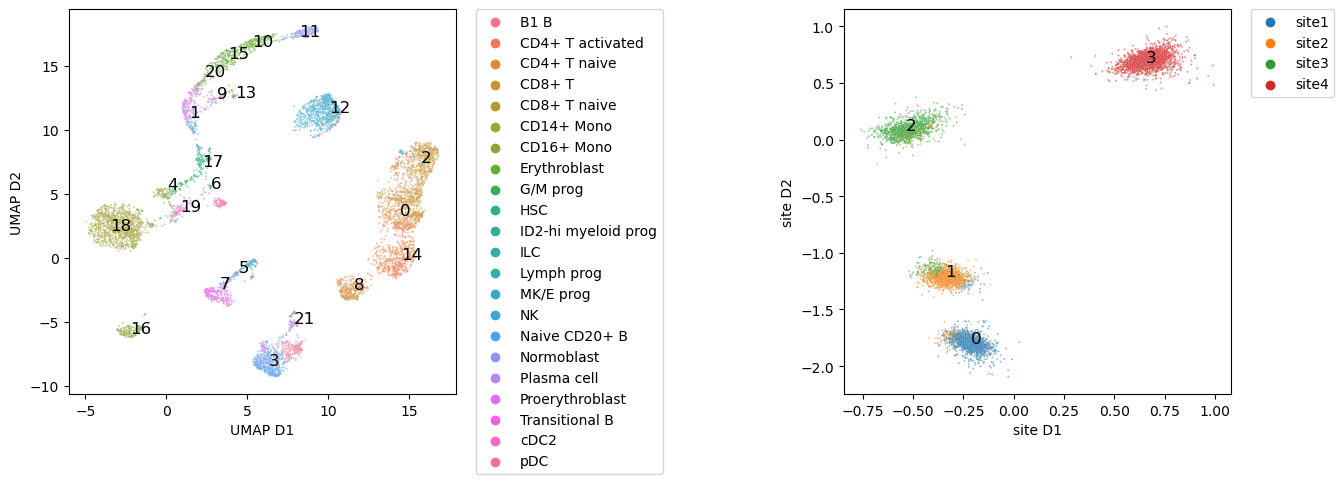

In [6]:
print("testset")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    data=plot_df,
    x="UMAP D1",
    y="UMAP D2",
    hue="celltype",
    s=2,
    alpha=0.5,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    data=plot_df,
    x="site D1",
    y="site D2",
    hue="site",
    s=2,
    alpha=0.5,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### plotting model results

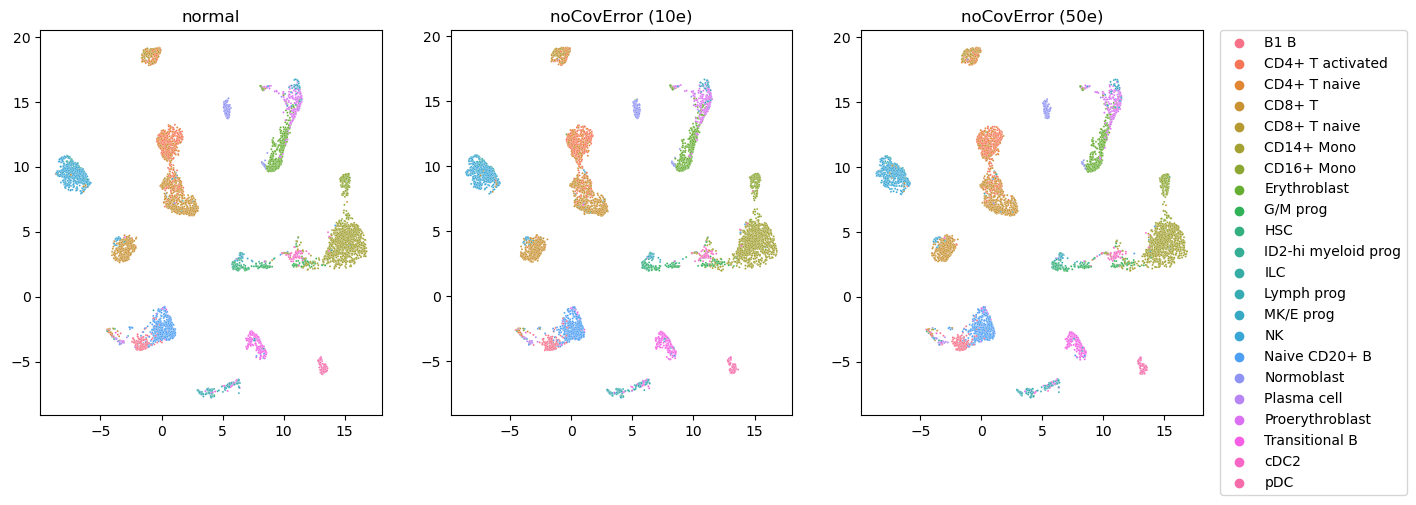

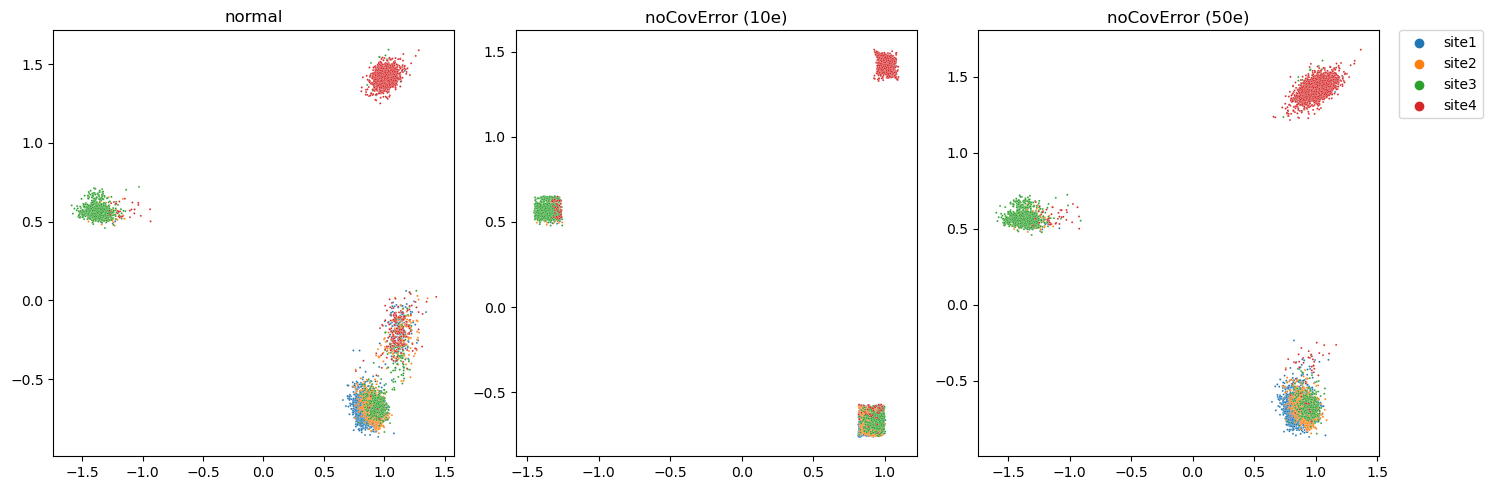

In [7]:
for i, model_name in enumerate(model_names):
    print(batches_left_out[i])

    # load model
    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_0 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t0 = model.test_rep.z.detach().cpu().numpy()

    # now get the test rep without covariate error
    model_name = model_name + "_test10e_noCovError"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_1 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t1 = model.test_rep.z.detach().cpu().numpy()

    # now get the test rep without covariate error
    model_name = model_name.replace("test10e", "test50e")

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_2 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t2 = model.test_rep.z.detach().cpu().numpy()

    # make 3 supplots, one for each rep
    reducer = umap.UMAP()
    reducer.fit_transform(model.representation.z.detach().cpu().numpy())

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j, rep in enumerate([rep_t0, rep_t1, rep_t2]):
        embedding = reducer.transform(rep)
        legend = False
        if j == 2:
            legend = True
        sns.scatterplot(
            x=embedding[:, 0],
            y=embedding[:, 1],
            hue=testset.obs["cell_type"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError (10e)", "noCovError (50e)"][j])
        # move the legend outside
        if j == 2:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    # make 3 subplots, one for each covariate rep, colored by the test batches

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j, rep in enumerate([rep_0, rep_1, rep_2]):
        legend = False
        if j == 2:
            legend = True
        sns.scatterplot(
            x=rep[:, 0],
            y=rep[:, 1],
            hue=testset.obs["Site"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError (10e)", "noCovError (50e)"][j])
        if j == 2:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

    break

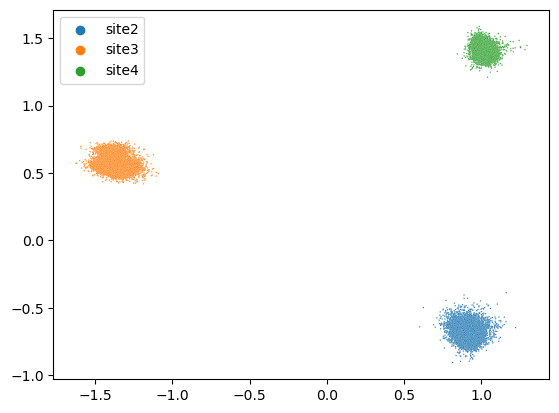

In [11]:
sns.scatterplot(
    x=model.correction_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_rep.z.detach().cpu().numpy()[:, 1],
    hue=trainset[train_indices].obs["Site"].values,
    s=1
)
plt.show()

site1
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True


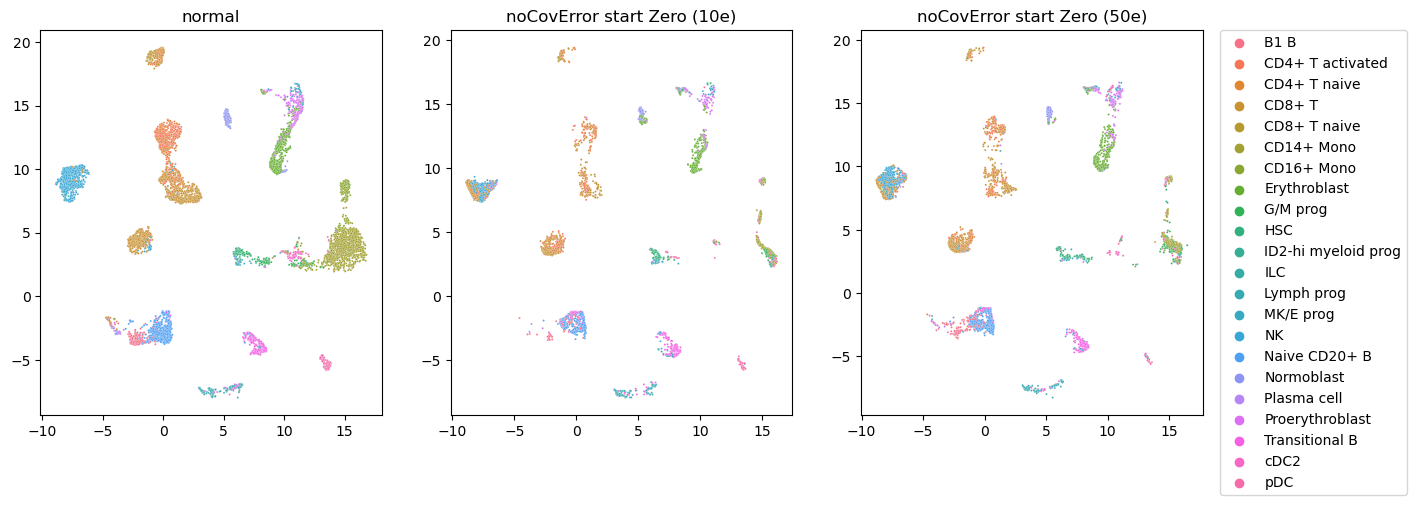

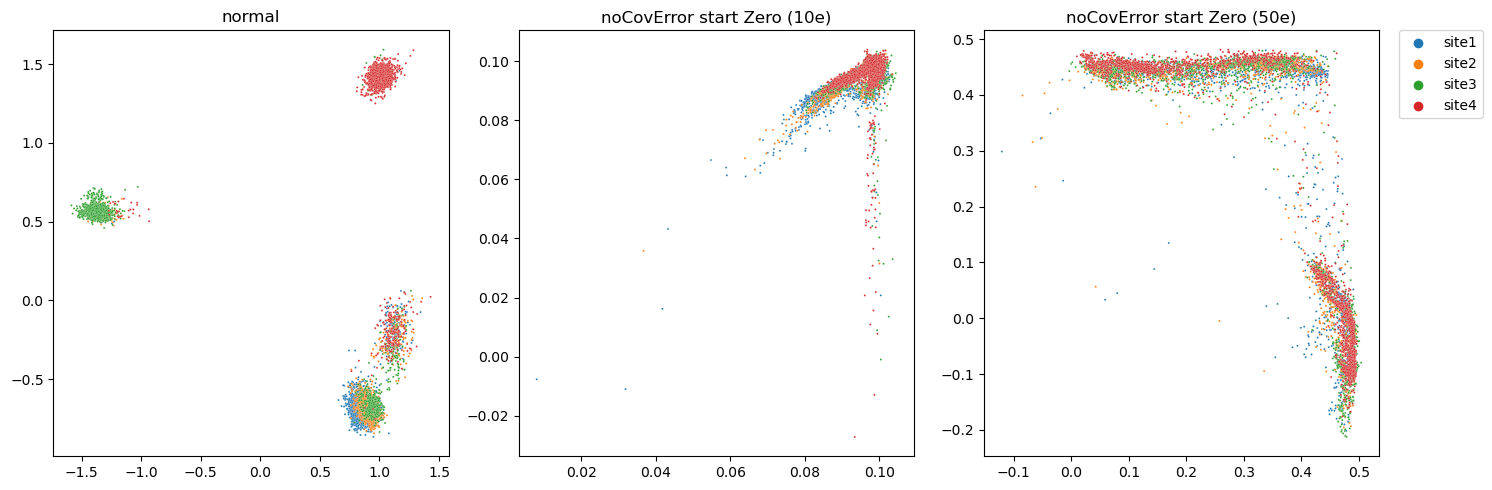

In [3]:
for i, model_name in enumerate(model_names):
    print(batches_left_out[i])

    # load model
    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_0 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t0 = model.test_rep.z.detach().cpu().numpy()

    # now get the test rep without covariate error
    model_name = model_name + "_test10e_noCovError_sZero"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_1 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t1 = model.test_rep.z.detach().cpu().numpy()

    # now get the test rep without covariate error
    model_name = model_name.replace("test10e", "test50e")

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_2 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t2 = model.test_rep.z.detach().cpu().numpy()

    # make 3 supplots, one for each rep
    reducer = umap.UMAP()
    reducer.fit_transform(model.representation.z.detach().cpu().numpy())

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j, rep in enumerate([rep_t0, rep_t1, rep_t2]):
        embedding = reducer.transform(rep)
        legend = False
        if j == 2:
            legend = True
        sns.scatterplot(
            x=embedding[:, 0],
            y=embedding[:, 1],
            hue=testset.obs["cell_type"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError start Zero (10e)", "noCovError start Zero (50e)"][j])
        # move the legend outside
        if j == 2:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    # make 3 subplots, one for each covariate rep, colored by the test batches

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j, rep in enumerate([rep_0, rep_1, rep_2]):
        legend = False
        if j == 2:
            legend = True
        sns.scatterplot(
            x=rep[:, 0],
            y=rep[:, 1],
            hue=testset.obs["Site"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError start Zero (10e)", "noCovError start Zero (50e)"][j])
        if j == 2:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

    break

site1
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True


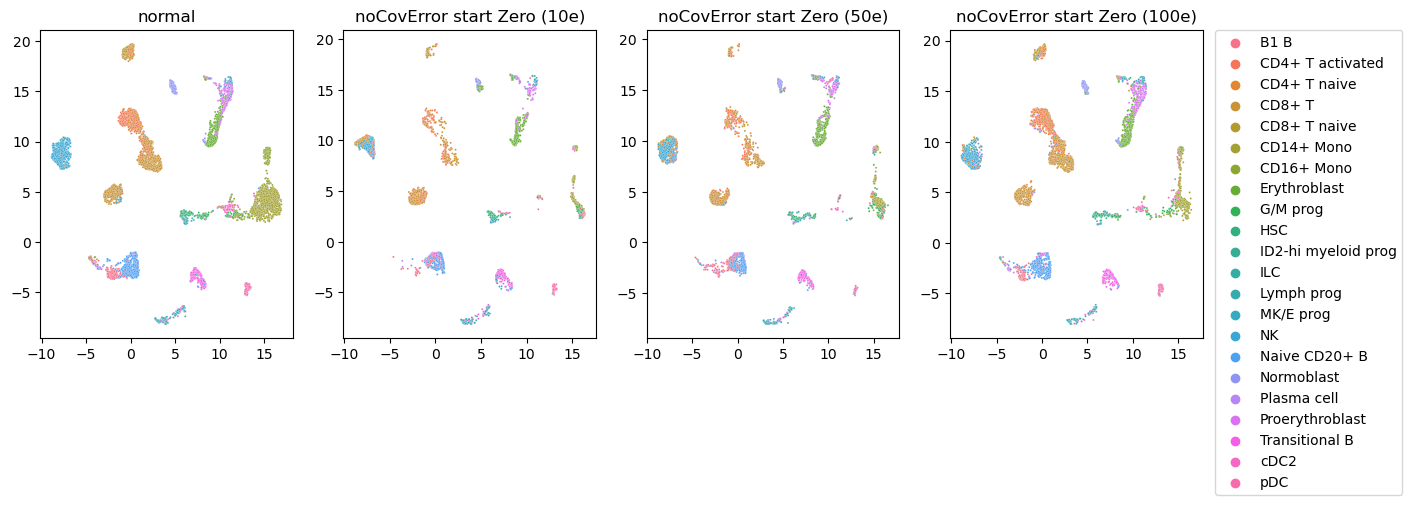

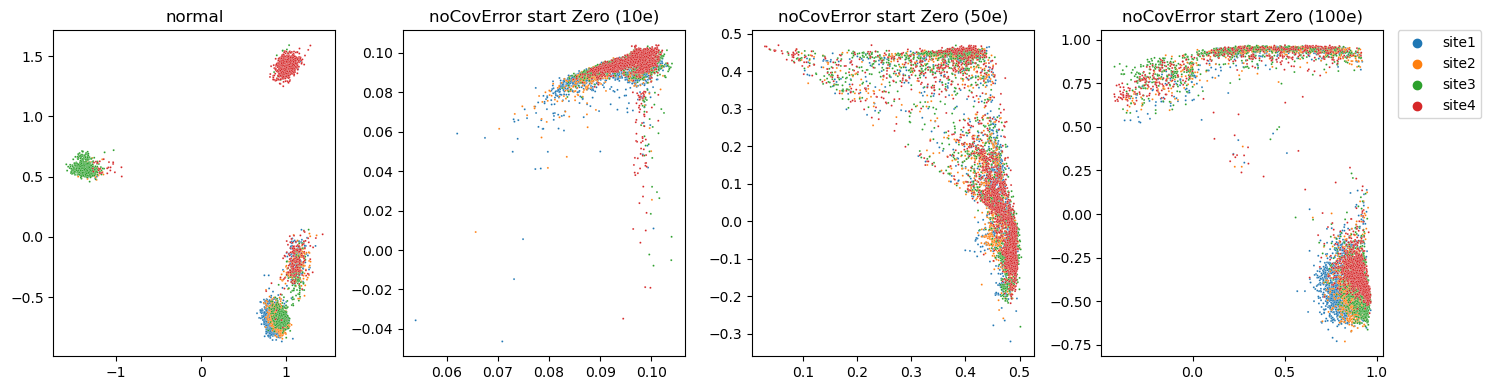

In [3]:
for i, model_name in enumerate(model_names):
    print(batches_left_out[i])

    # load model
    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_0 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t0 = model.test_rep.z.detach().cpu().numpy()
    model = None

    # now get the test rep without covariate error
    model_name = model_name + "_test10e_sZero"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_1 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t1 = model.test_rep.z.detach().cpu().numpy()
    model = None

    # now get the test rep without covariate error
    model_name = model_name.replace("test10e", "test50e")

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_2 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t2 = model.test_rep.z.detach().cpu().numpy()
    model = None

    # now get the test rep without covariate error
    model_name = model_name.replace("test50e", "test100e")

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_3 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t3 = model.test_rep.z.detach().cpu().numpy()

    # make 3 supplots, one for each rep
    reducer = umap.UMAP()
    reducer.fit_transform(model.representation.z.detach().cpu().numpy())

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for j, rep in enumerate([rep_t0, rep_t1, rep_t2, rep_t3]):
        embedding = reducer.transform(rep)
        legend = False
        if j == 3:
            legend = True
        sns.scatterplot(
            x=embedding[:, 0],
            y=embedding[:, 1],
            hue=testset.obs["cell_type"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError start Zero (10e)", "noCovError start Zero (50e)", "noCovError start Zero (100e)"][j])
        # move the legend outside
        if j == 3:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    # make 3 subplots, one for each covariate rep, colored by the test batches

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for j, rep in enumerate([rep_0, rep_1, rep_2, rep_3]):
        legend = False
        if j == 3:
            legend = True
        sns.scatterplot(
            x=rep[:, 0],
            y=rep[:, 1],
            hue=testset.obs["Site"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError start Zero (10e)", "noCovError start Zero (50e)", "noCovError start Zero (100e)"][j])
        if j == 3:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

    break

site1
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True
CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True


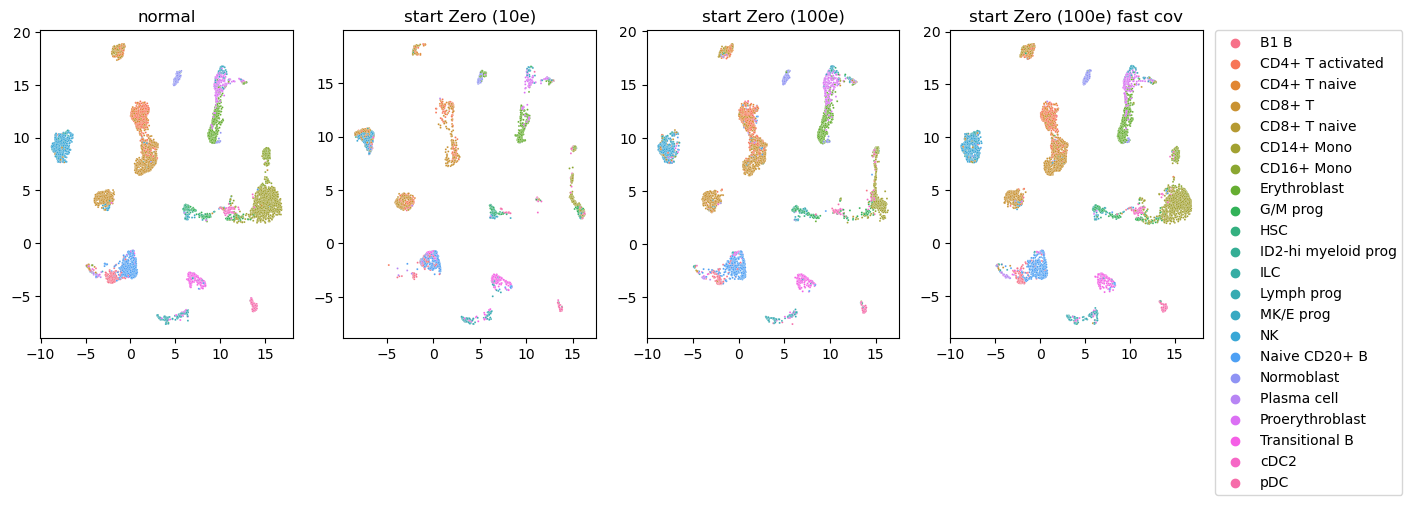

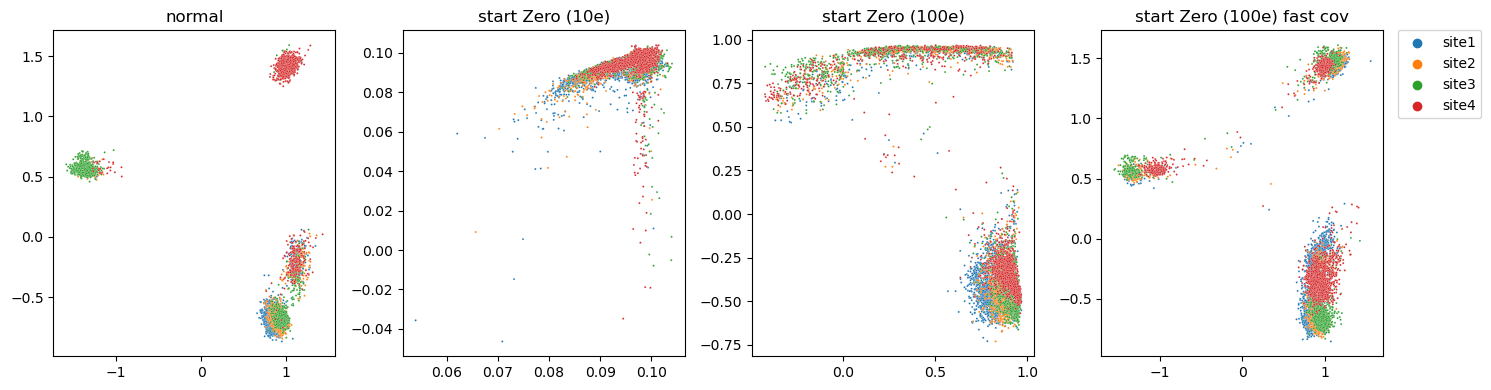

In [4]:
for i, model_name in enumerate(model_names):
    print(batches_left_out[i])

    # load model
    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_0 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t0 = model.test_rep.z.detach().cpu().numpy()
    model = None

    # now get the test rep without covariate error
    model_name = model_name + "_test10e_sZero"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_1 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t1 = model.test_rep.z.detach().cpu().numpy()
    model = None

    # now get the test rep without covariate error
    model_name = model_name.replace("test10e", "test100e")

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_2 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t2 = model.test_rep.z.detach().cpu().numpy()

    model = None

    # now get the test rep without covariate error
    model_name = model_name + "_covFast"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_3 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t3 = model.test_rep.z.detach().cpu().numpy()

    # make 3 supplots, one for each rep
    reducer = umap.UMAP()
    reducer.fit_transform(model.representation.z.detach().cpu().numpy())

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for j, rep in enumerate([rep_t0, rep_t1, rep_t2, rep_t3]):
        embedding = reducer.transform(rep)
        legend = False
        if j == 3:
            legend = True
        sns.scatterplot(
            x=embedding[:, 0],
            y=embedding[:, 1],
            hue=testset.obs["cell_type"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "start Zero (10e)", "start Zero (100e)", "start Zero (100e) fast cov"][j])
        # move the legend outside
        if j == 3:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    # make 3 subplots, one for each covariate rep, colored by the test batches

    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for j, rep in enumerate([rep_0, rep_1, rep_2, rep_3]):
        legend = False
        if j == 3:
            legend = True
        sns.scatterplot(
            x=rep[:, 0],
            y=rep[:, 1],
            hue=testset.obs["Site"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "start Zero (10e)", "start Zero (100e)", "start Zero (100e) fast cov"][j])
        if j == 3:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

    break

In [ ]:
for i, model_name in enumerate(model_names):
    print(batches_left_out[i])

    # load model
    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_0 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t0 = model.test_rep.z.detach().cpu().numpy()

    # now get the test rep without covariate error
    model_name = model_name + "_test50e_noCovError"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_1 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t1 = model.test_rep.z.detach().cpu().numpy()

    # now get the test rep without covariate error
    model_name = model_name + "_sZero"

    train_indices = [
        x
        for x in np.arange(len(trainset))
        if trainset.obs["Site"].values[x] != batches_left_out[i]
    ]
    model = DGD.load(
        data=trainset[train_indices],
        save_dir=save_dir + data_name + "/",
        model_name=model_name,
    )

    rep_2 = model.correction_test_rep.z.detach().cpu().numpy()
    rep_t2 = model.test_rep.z.detach().cpu().numpy()

    # make 3 supplots, one for each rep
    reducer = umap.UMAP()
    reducer.fit_transform(model.representation.z.detach().cpu().numpy())

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j, rep in enumerate([rep_t0, rep_t1, rep_t2]):
        embedding = reducer.transform(rep)
        legend = False
        if j == 2:
            legend = True
        sns.scatterplot(
            x=embedding[:, 0],
            y=embedding[:, 1],
            hue=testset.obs["cell_type"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError (50e)", "noCovError start at zero (50e)"][j])
        # move the legend outside
        if j == 2:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    # make 3 subplots, one for each covariate rep, colored by the test batches

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j, rep in enumerate([rep_0, rep_1, rep_2]):
        legend = False
        if j == 2:
            legend = True
        sns.scatterplot(
            x=rep[:, 0],
            y=rep[:, 1],
            hue=testset.obs["Site"].values,
            ax=ax[j],
            legend=legend,
            s=2
        )
        ax[j].set_title(["normal", "noCovError (50e)", "noCovError start at zero (50e)"][j])
        if j == 2:
            ax[j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

    break

### where are the representations being sorted and where do they go?

In [3]:
i = 0
model_name = model_names[i]

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True


In [4]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

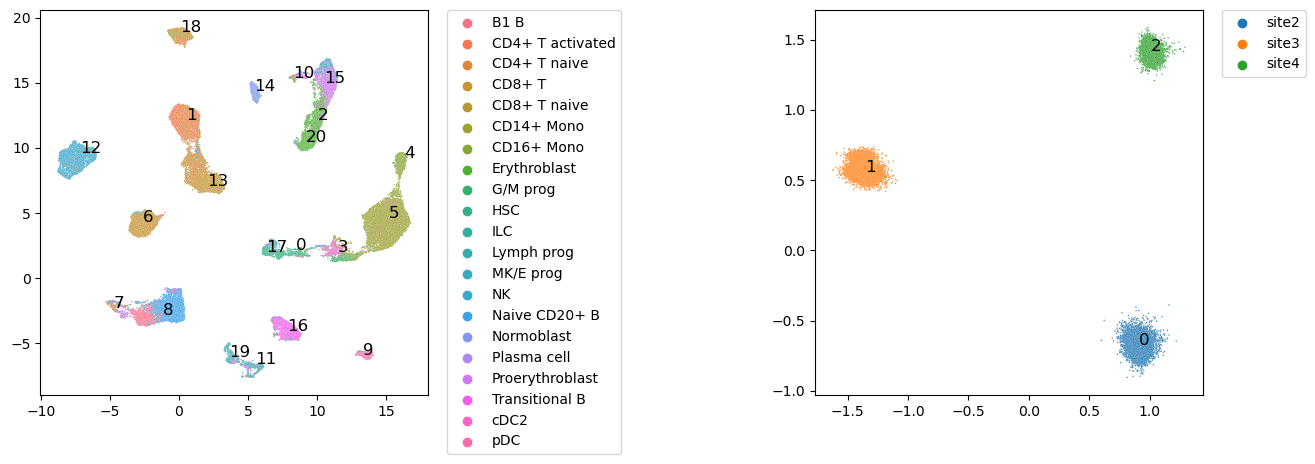

In [59]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=trainset[train_indices].obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_rep.z.detach().cpu().numpy()[:, 1],
    hue=trainset[train_indices].obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [5]:
import torch

In [16]:
# do one step, so I can then look at what test representations go into the "wrong" cluster based on the train rep

original_name = model._model_name
model._model_name = original_name + "_test1e_plot"
model.predict_new(testset, n_epochs=1)
print("   test set inferred (long)")

# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_15030/2081721557.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(celltype_indices)


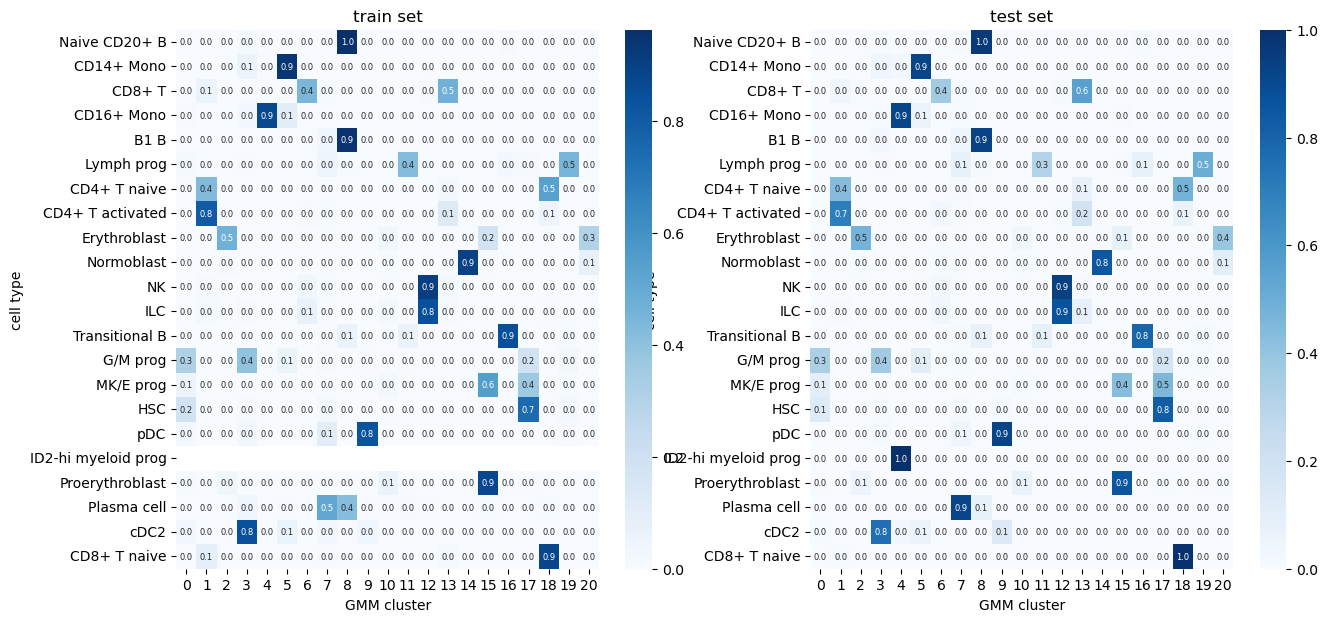

In [52]:
# make a confusion matrix showing the fraction of cells in each cluster
# first for cell types and gmm clusters for train and test sets
# second for sites and correction_gmm clusters

# for cell types
# first make the confusion matrix
celltypes = trainset.obs["cell_type"].unique()
confusion_matrix = np.zeros((len(celltypes), model.gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(celltypes), model.gmm.n_mix_comp))
for i, celltype in enumerate(celltypes):
    # get the indices of the trainset that are of this celltype
    celltype_indices = np.where(trainset[train_indices].obs["cell_type"].values == celltype)[0]
    celltype_indices_test = np.where(testset.obs["cell_type"].values == celltype)[0]
    # get the clusters that these indices are in
    clusters = train_basal_clusters[celltype_indices].cpu().numpy()
    clusters_test = test_basal_clusters[celltype_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(celltype_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(celltype_indices_test)
# normalize the confusion matrix
#confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=0)
#confusion_matrix_test = confusion_matrix_test / np.sum(confusion_matrix_test, axis=0)
# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("cell type")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("cell type")
ax[1].set_title("test set")
plt.show()

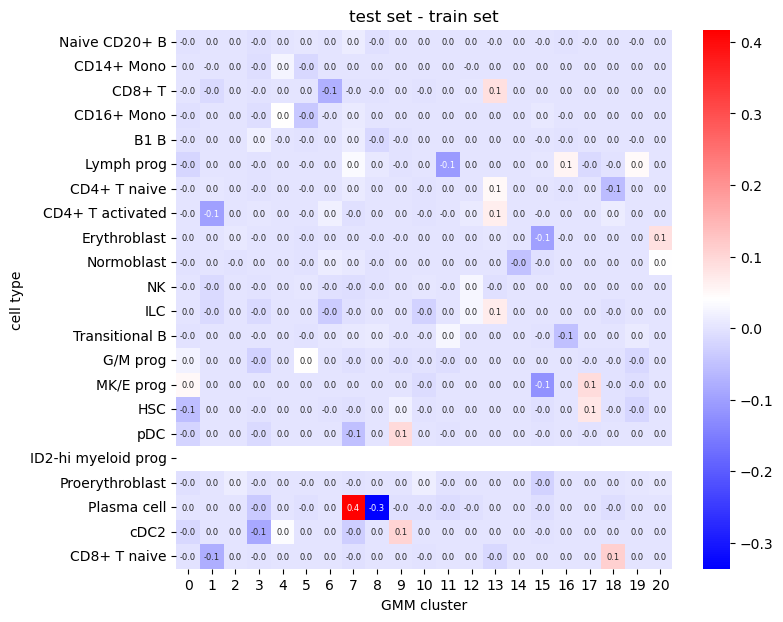

In [54]:
# now plot a heatmap of the difference
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(confusion_matrix_test - confusion_matrix, cmap="bwr", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax, annot_kws={"fontsize": 6})
ax.set_xlabel("GMM cluster")
ax.set_ylabel("cell type")
ax.set_title("test set - train set")
plt.show()

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_15030/309398976.py:15: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


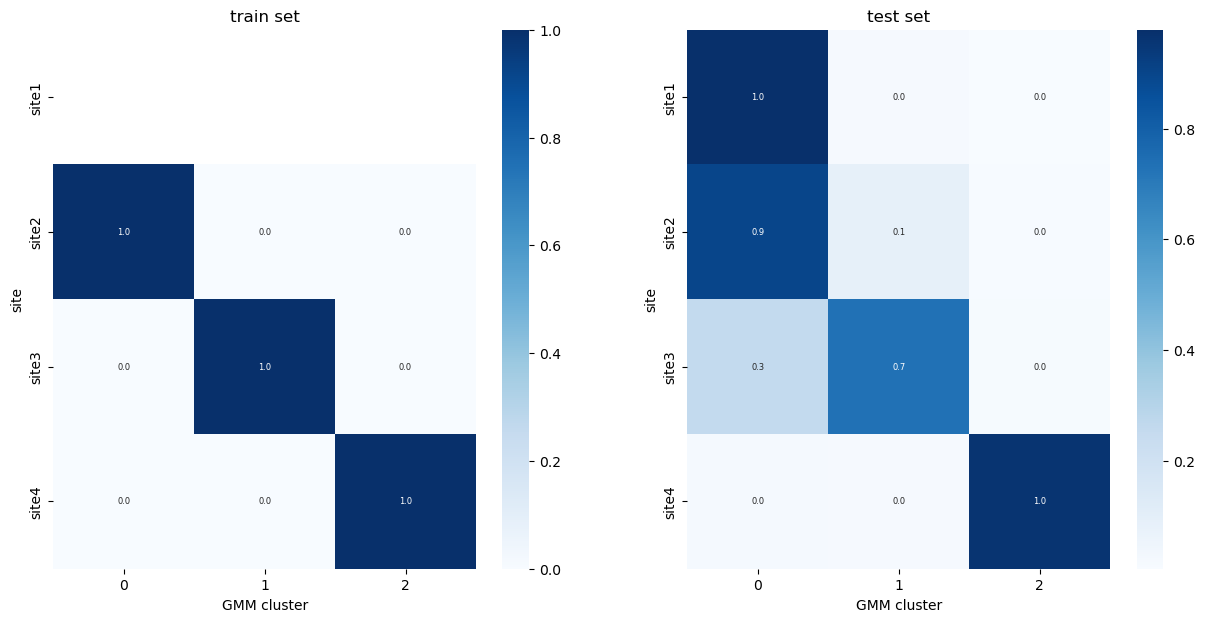

In [56]:
# same for covariates

sites = trainset.obs["Site"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["Site"].values == site)[0]
    site_indices_test = np.where(testset.obs["Site"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

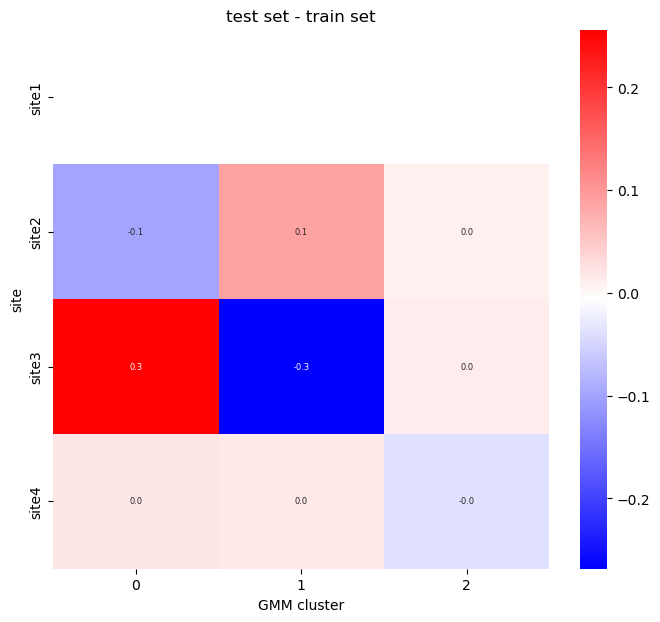

In [57]:
# now plot the difference
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(confusion_matrix_test - confusion_matrix, cmap="bwr", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax, annot_kws={"fontsize": 6})
ax.set_xlabel("GMM cluster")
ax.set_ylabel("site")
ax.set_title("test set - train set")
plt.show()

In [6]:
original_name = model._model_name
model._model_name = original_name + "_test50e_plot"
model.predict_new(testset, n_epochs=10)
print("   test set inferred (long)")

calculating losses for each new sample and potential reps
training selected reps for  10  epochs
epoch:  0  loss:  0.19746545706149338
epoch:  1  loss:  0.1967222096532586
epoch:  2  loss:  0.196412150832315
epoch:  3  loss:  0.19627702946885217
epoch:  4  loss:  0.19619291377831743
epoch:  5  loss:  0.19613428666606814
epoch:  6  loss:  0.19609614099322006
epoch:  7  loss:  0.19607098864571046
epoch:  8  loss:  0.19605307439049952
epoch:  9  loss:  0.19604175390032216
   test set inferred (long)


In [7]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters_2 = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters_2 = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters_2 = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters_2 = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

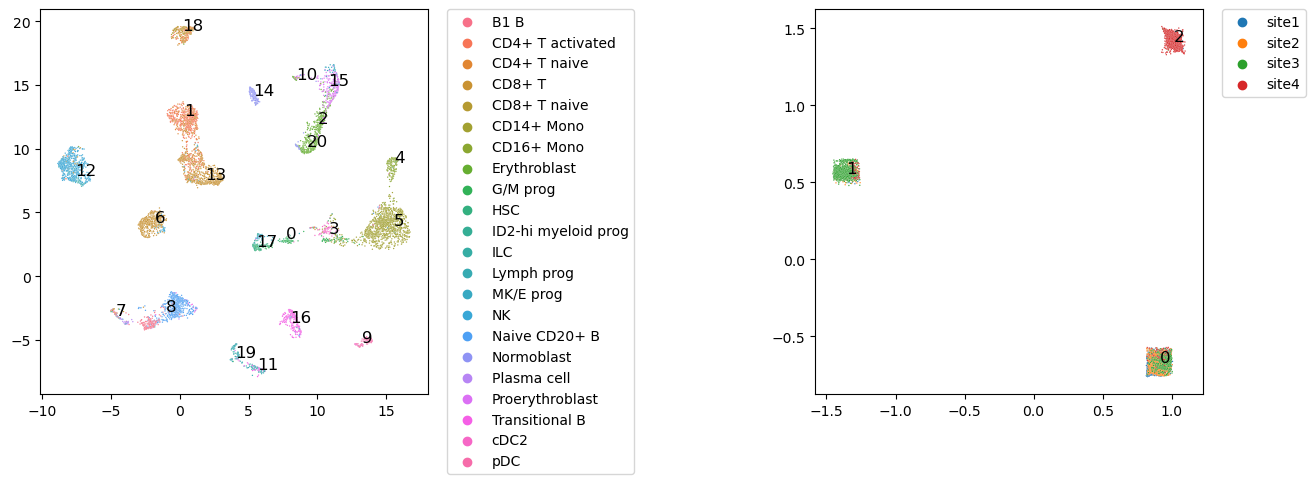

In [9]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_20961/3757675751.py:13: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


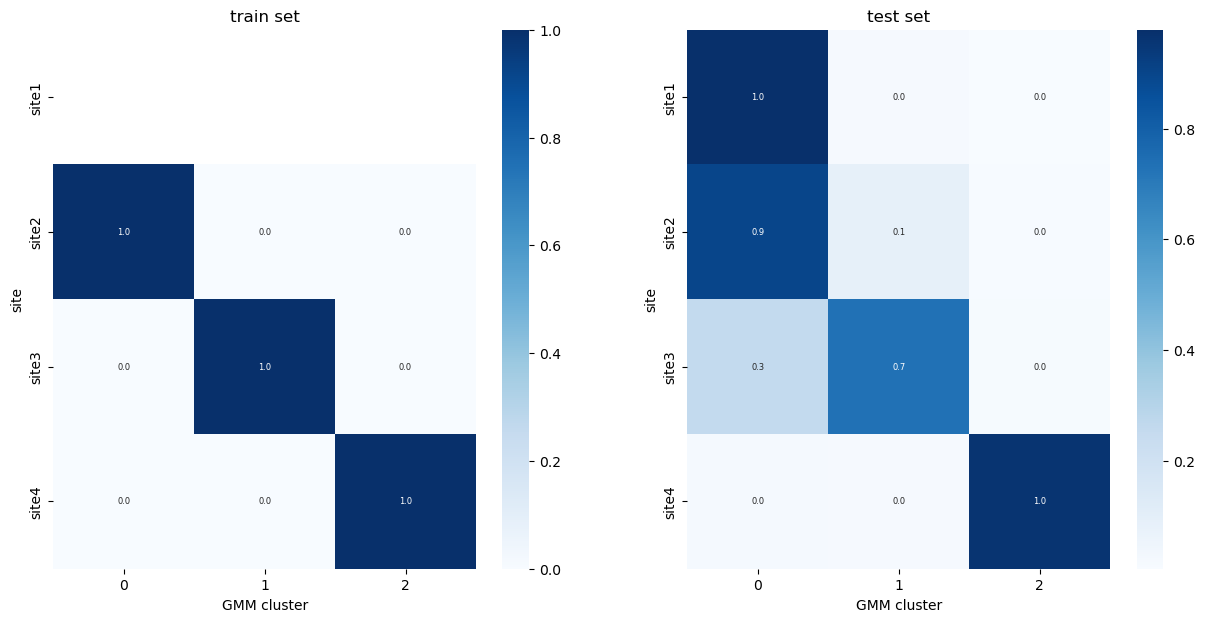

In [11]:
sites = trainset.obs["Site"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["Site"].values == site)[0]
    site_indices_test = np.where(testset.obs["Site"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters_2[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters_2[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

### try initializing the test set supervised

In [3]:
i = 0
model_name = model_names[i]

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
#######################
Training status
#######################
True


In [7]:
# get the covariate components for each covariate of the train set
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
# check which covariate label is in which cluster
train_batches = trainset[train_indices].obs["Site"].values
batch_id_dict = {}
for i, batch in enumerate(batches_left_out):
    if len(train_covariate_clusters[train_batches == batch]) > 0:
        majority_cluster = torch.median(train_covariate_clusters[train_batches == batch]).to(torch.int16).item()
        batch_id_dict[batch] = majority_cluster
    else:
        batch_id_dict[batch] = -1
print(batch_id_dict)

# now create a list of the test samples with the correct cluster
init_covariate_supervised = [batch_id_dict[batch] for batch in test_batches]
indices_of_new_distribution = np.where(np.array(init_covariate_supervised) == -1)[0]

{'site1': -1, 'site2': 0, 'site3': 1, 'site4': 2}


In [5]:
model.correction_gmm.mean

Parameter containing:
tensor([[ 0.9105, -0.6712],
        [-1.3561,  0.5592],
        [ 1.0136,  1.4173]], requires_grad=True)

In [8]:
original_name = model._model_name
model._model_name = original_name + "_test1e_plot"
model.predict_new(testset, n_epochs=1, indices_of_new_distribution=indices_of_new_distribution, start_from_zero=[False,True], init_covariate_supervised=init_covariate_supervised)
print("   test set inferred (long)")

Will learn extra components in the batch GMM
adding 1 new correction classes
old correction model:  
        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
         Parameter containing:
tensor([[ 0.9105, -0.6712],
        [-1.3561,  0.5592],
        [ 1.0136,  1.4173]], requires_grad=True)
new correction model:  
        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
calculating losses for each new sample and potential reps
(array([-1,  0,  1,  2]), array([1732, 1534, 1464, 2195]))
(array([0, 1, 2, 3]), array([1534, 1464, 2195, 1732]))
cov means shape
[3 3 3 ... 2 2 2]
correction model shape, assigned component and its mean shape
3
correction model shape, assigned component and its mean shape
3
correction model shape, assigned component and its mean shape
3
correction model shape, assigned component and its mean shape
3
correction model shape, assigned component and its mean shape
3
correction

In [9]:
model.correction_gmm.mean

Parameter containing:
tensor([[ 9.1045e-01, -6.7125e-01],
        [-1.3561e+00,  5.5916e-01],
        [ 1.0136e+00,  1.4173e+00],
        [-1.7504e-03,  9.5410e-04]], requires_grad=True)

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_64790/2007496312.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


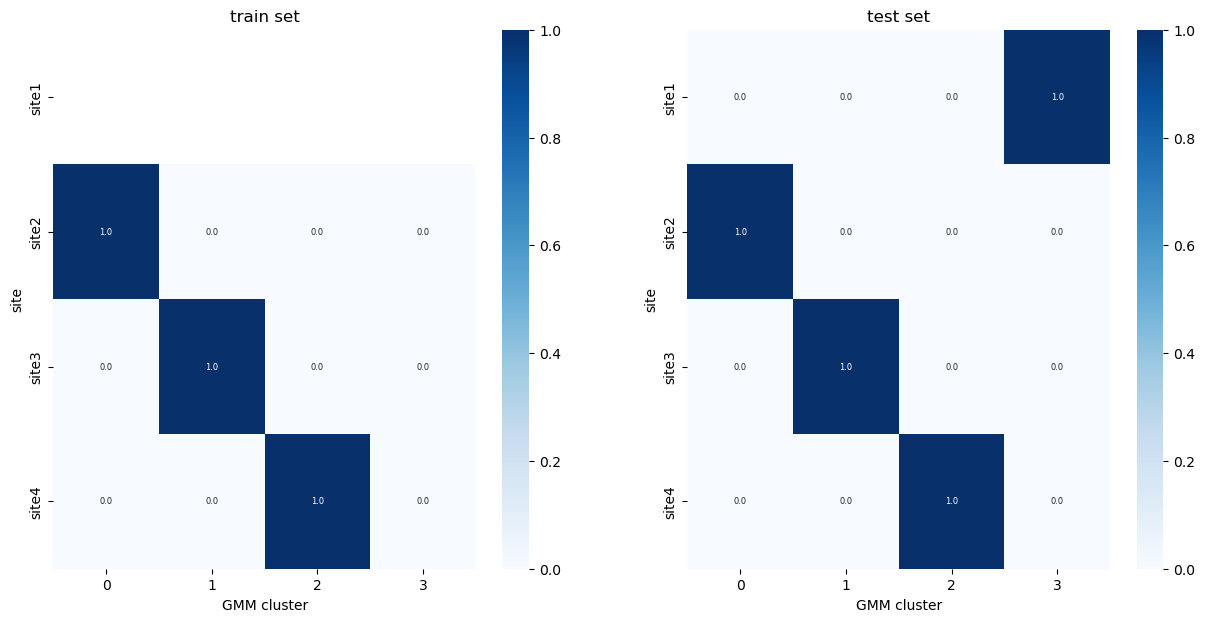

In [10]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

sites = trainset.obs["Site"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["Site"].values == site)[0]
    site_indices_test = np.where(testset.obs["Site"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

In [9]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

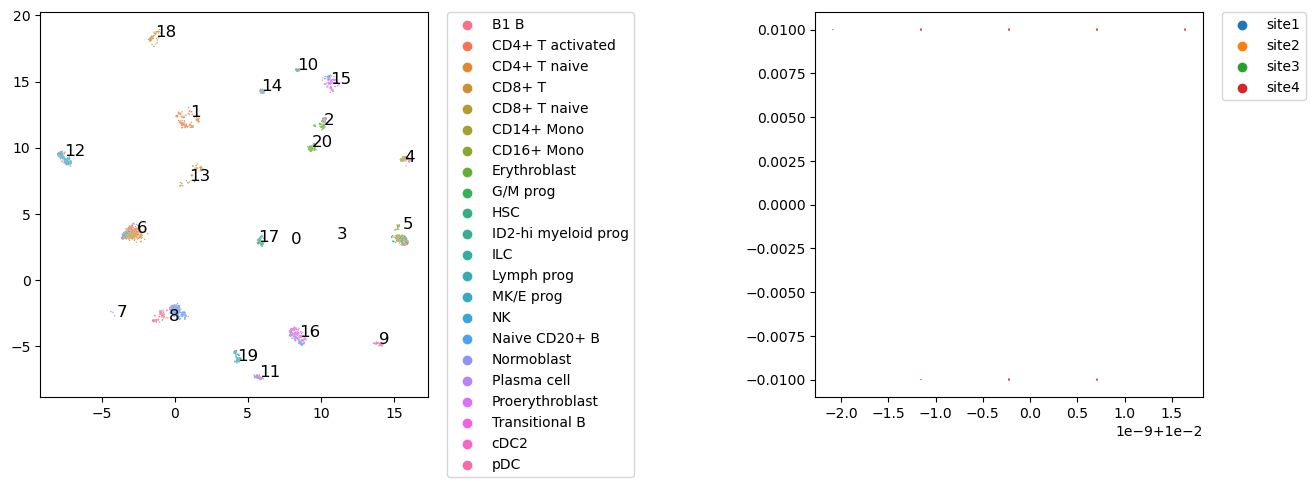

In [11]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
#for i in range(model.correction_gmm.n_mix_comp):
#    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
original_name = model._model_name
model._model_name = original_name + "_test10e_plot"
model.predict_new(testset, n_epochs=10, indices_of_new_distribution=indices_of_new_distribution, start_from_zero=[False,True], init_covariate_supervised=init_covariate_supervised)
print("   test set inferred (long)")

In [6]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test10e_sup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
4
2
#######################
Training status
#######################
True


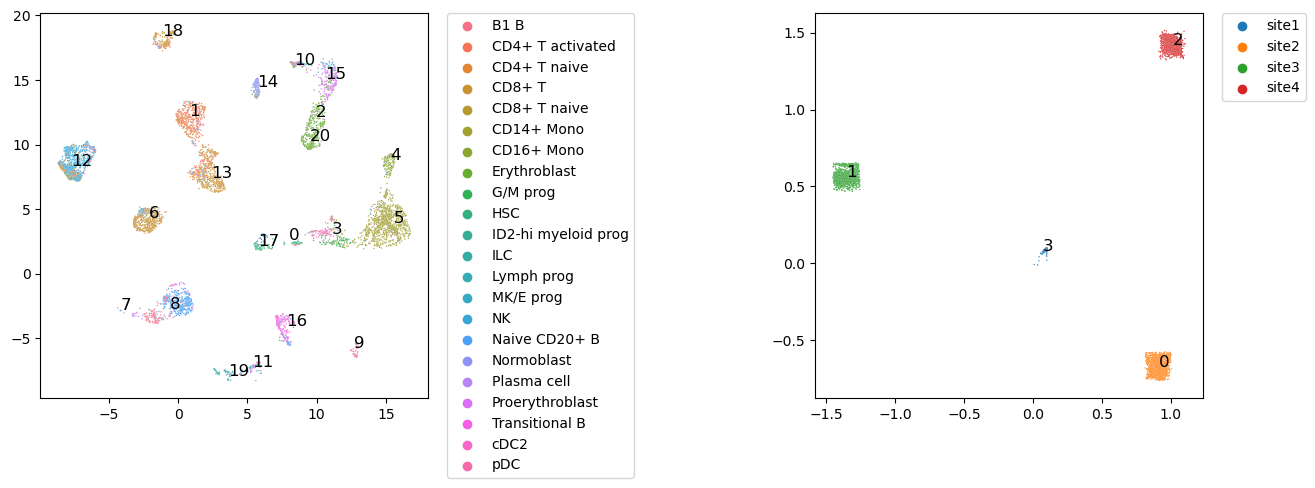

In [7]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test20e_sup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


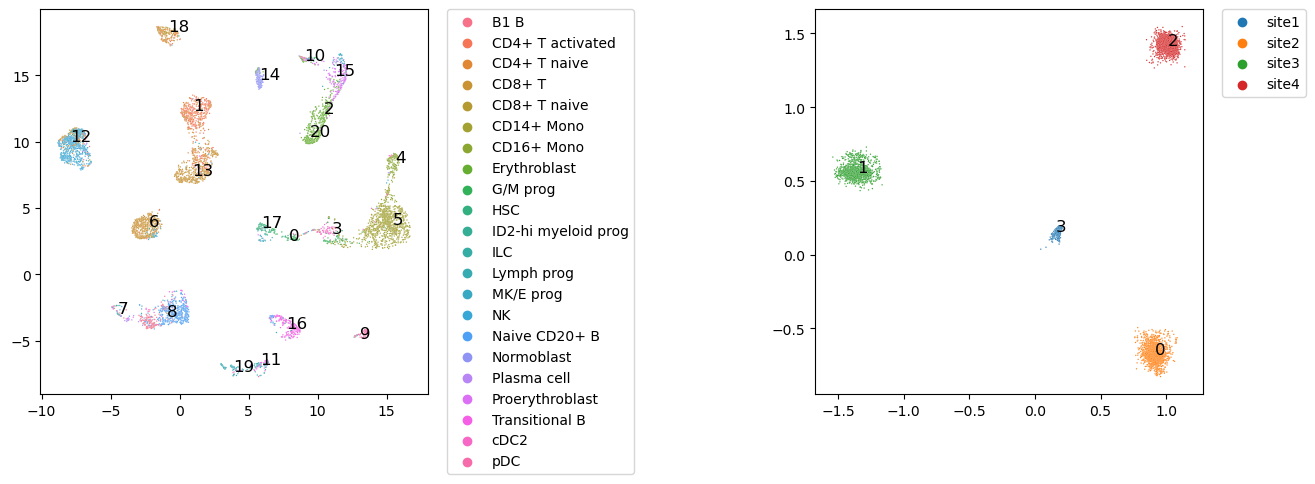

In [11]:
#reducer = umap.UMAP()
#rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
#gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_sup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
4
2
#######################
Training status
#######################
True


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_99248/2007496312.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


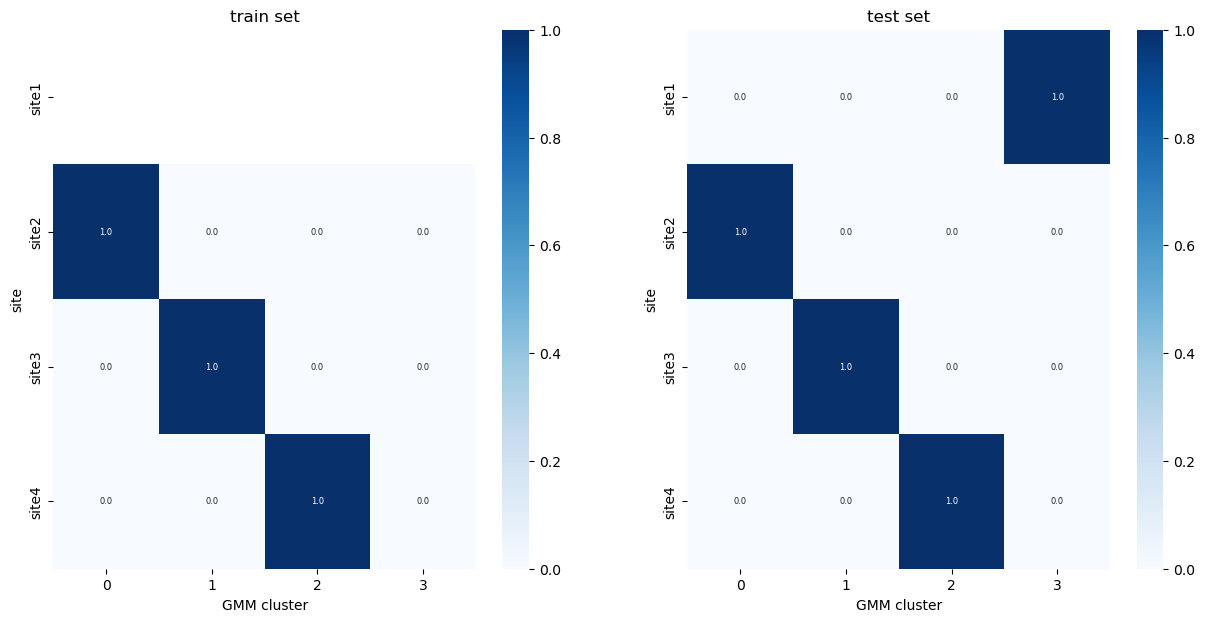

In [4]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

sites = trainset.obs["Site"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["Site"].values == site)[0]
    site_indices_test = np.where(testset.obs["Site"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

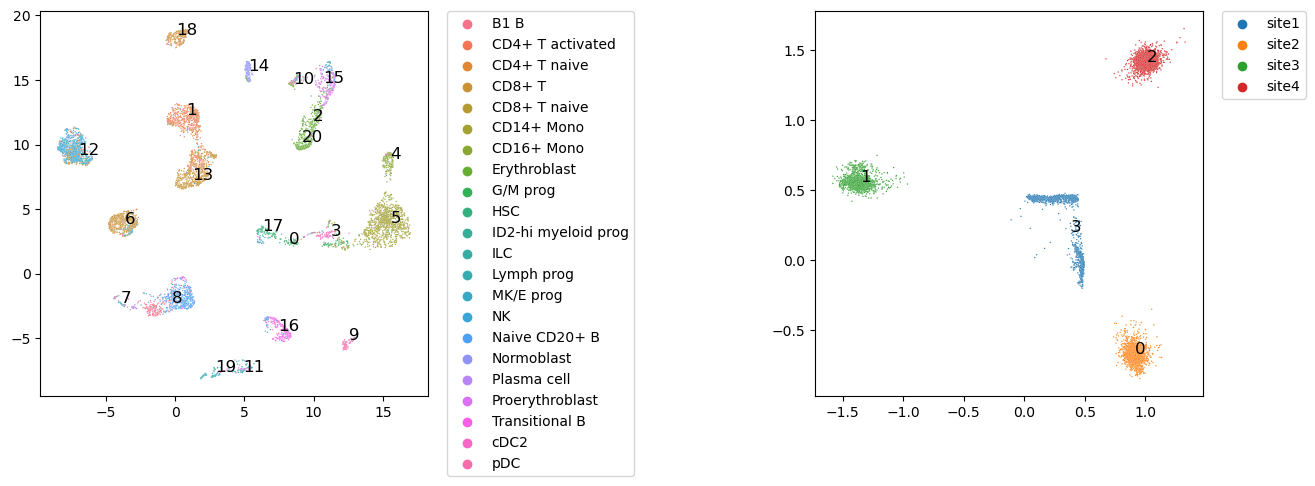

In [5]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test20e_supsup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [ ]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test30e_supsup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


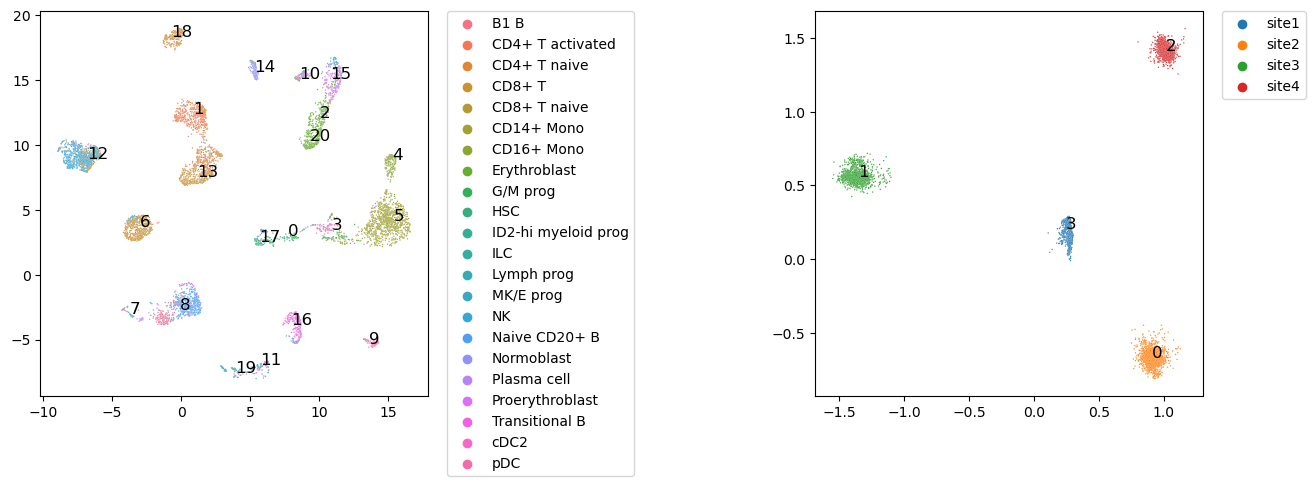

In [13]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test40e_supsup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


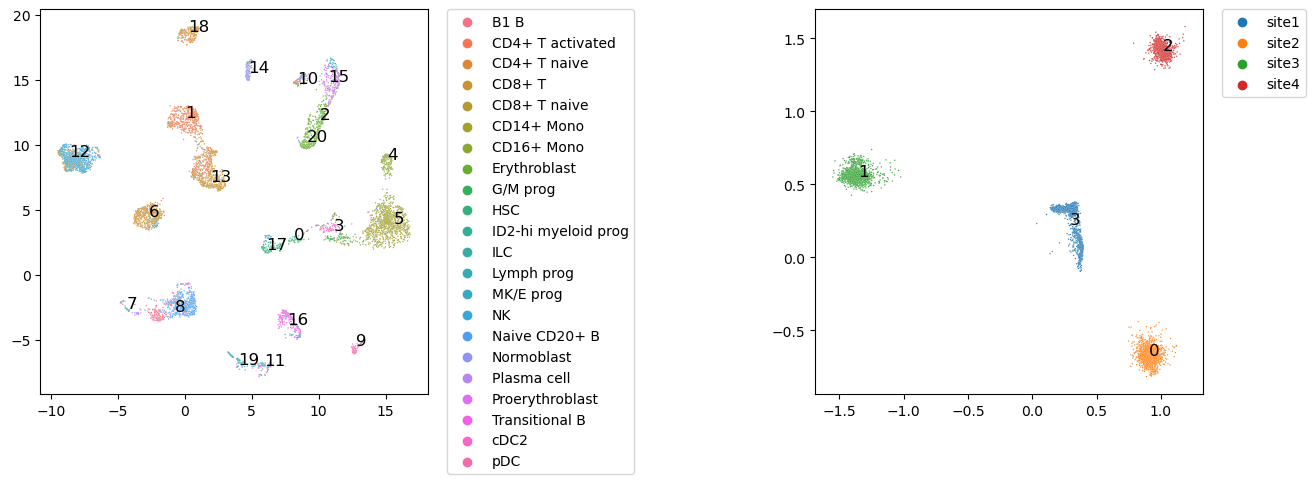

In [4]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [16]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_supsup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


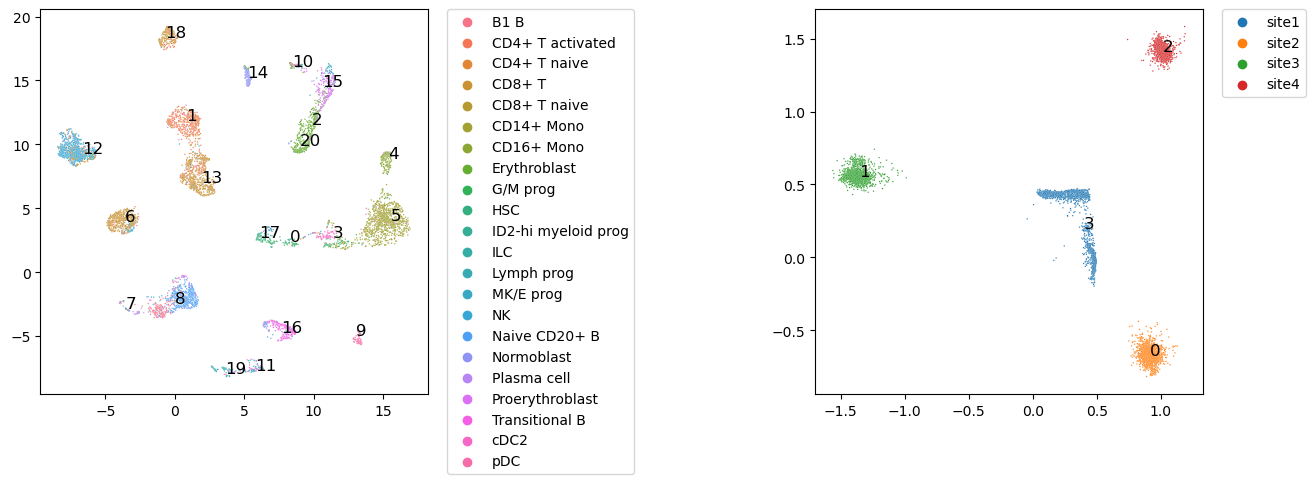

In [17]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [18]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_supsup2"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


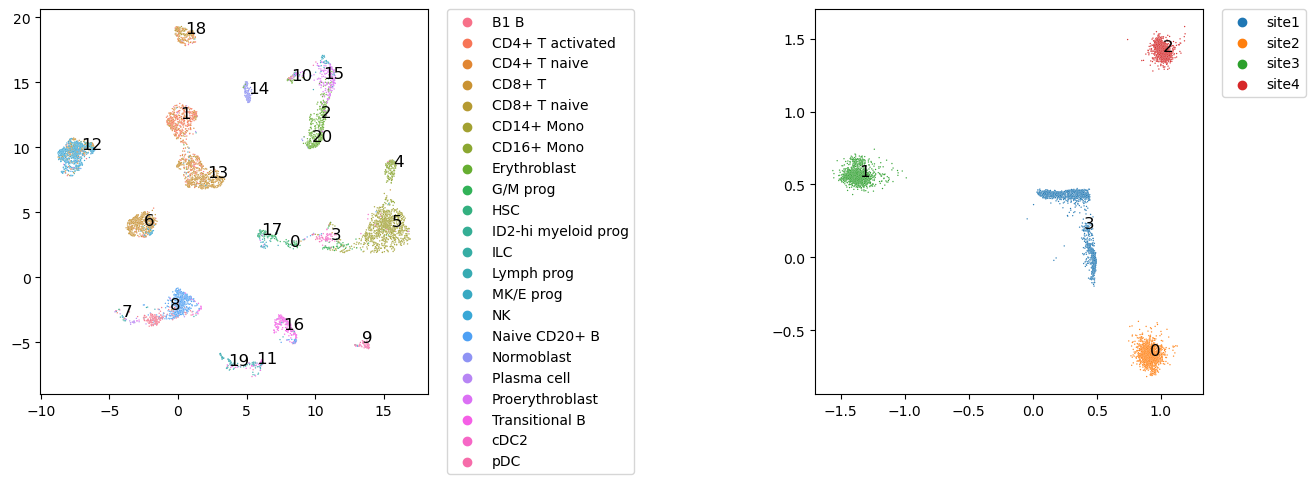

In [19]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [14]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test100e_supsup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


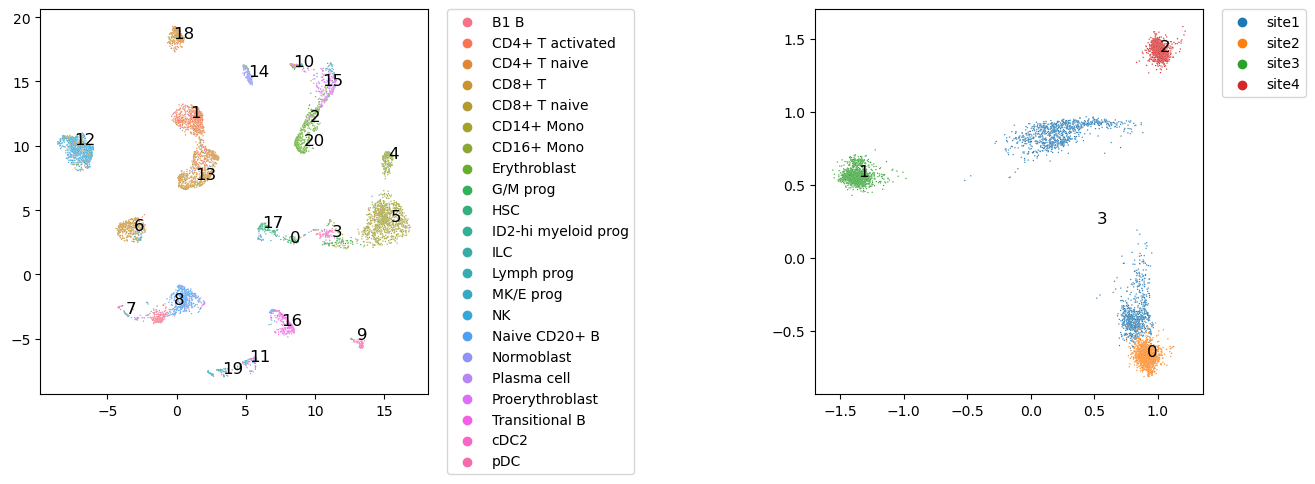

In [15]:
reducer = umap.UMAP()
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test100e_sup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
4
2
#######################
Training status
#######################
True


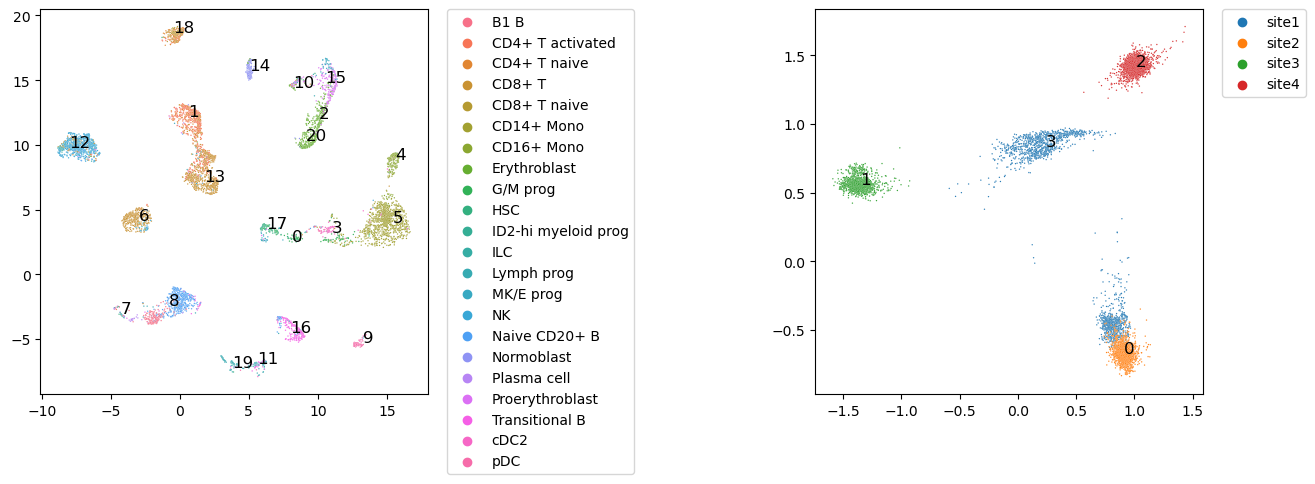

In [4]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test200e_sup"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


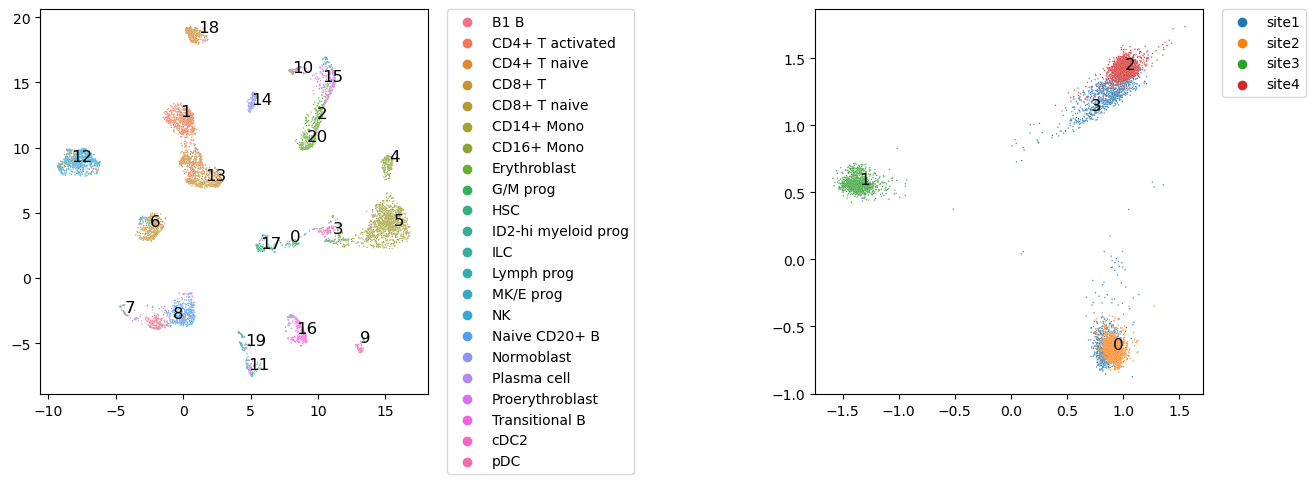

In [4]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [11]:
model = None

### supervised and fine-tuned

In [6]:
model = None

In [6]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test10e_sup_finetuned"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


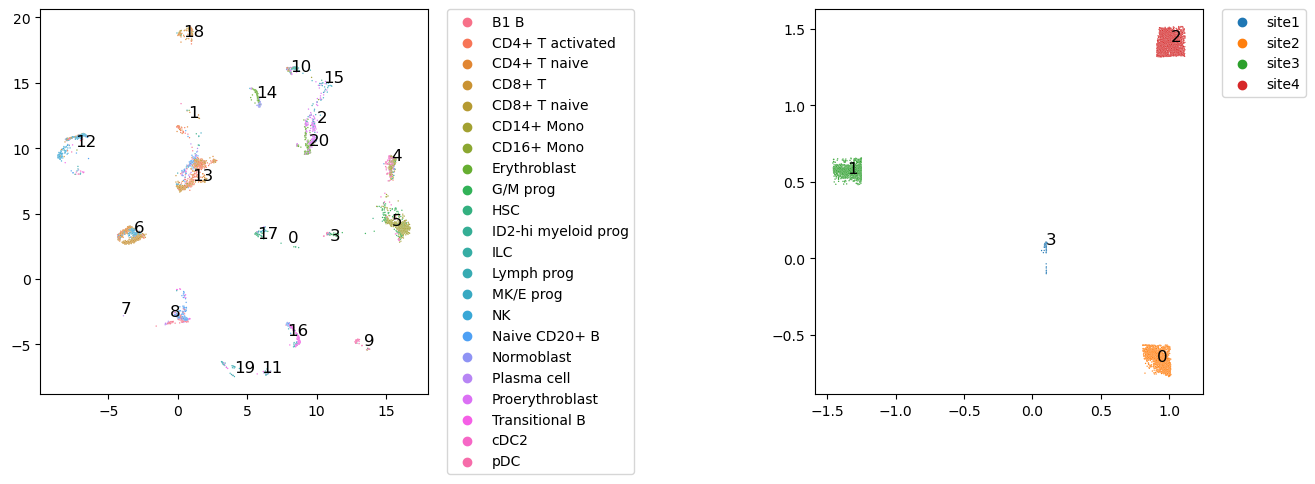

In [7]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_sup_finetuned"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


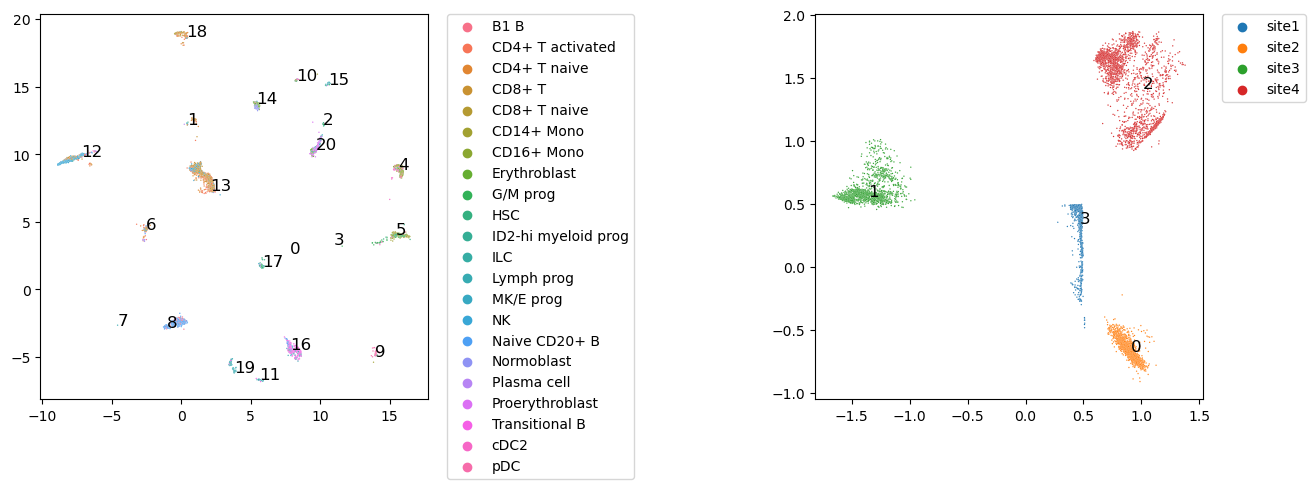

In [4]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_sup_finetuned2"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


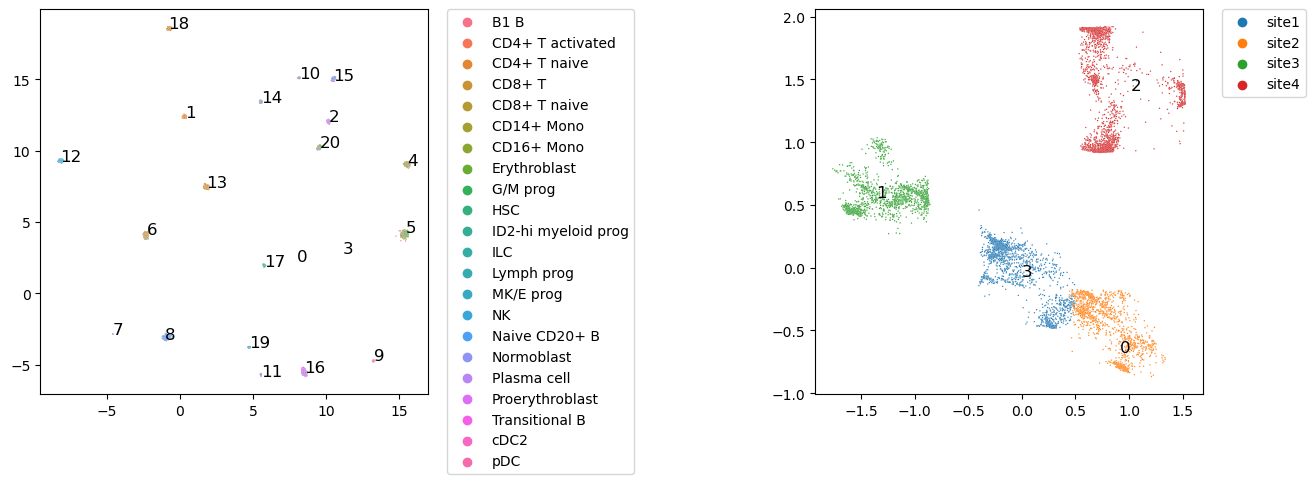

In [4]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
# this one has a 20 epoch warmup before finetuning the decoder weights
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_sup_finetuned3"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


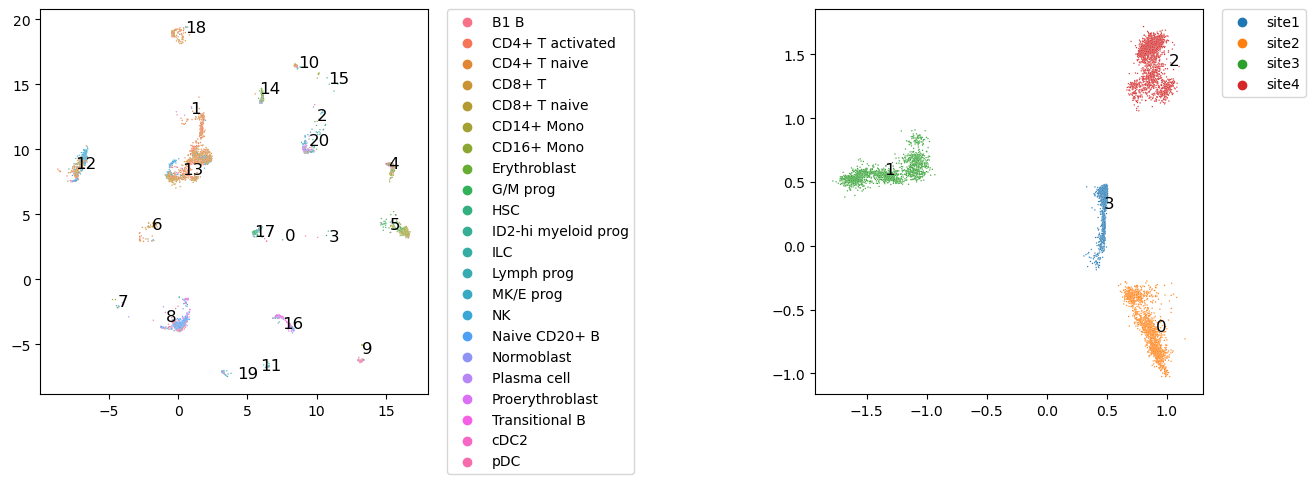

In [8]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test100e_sup_finetuned"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


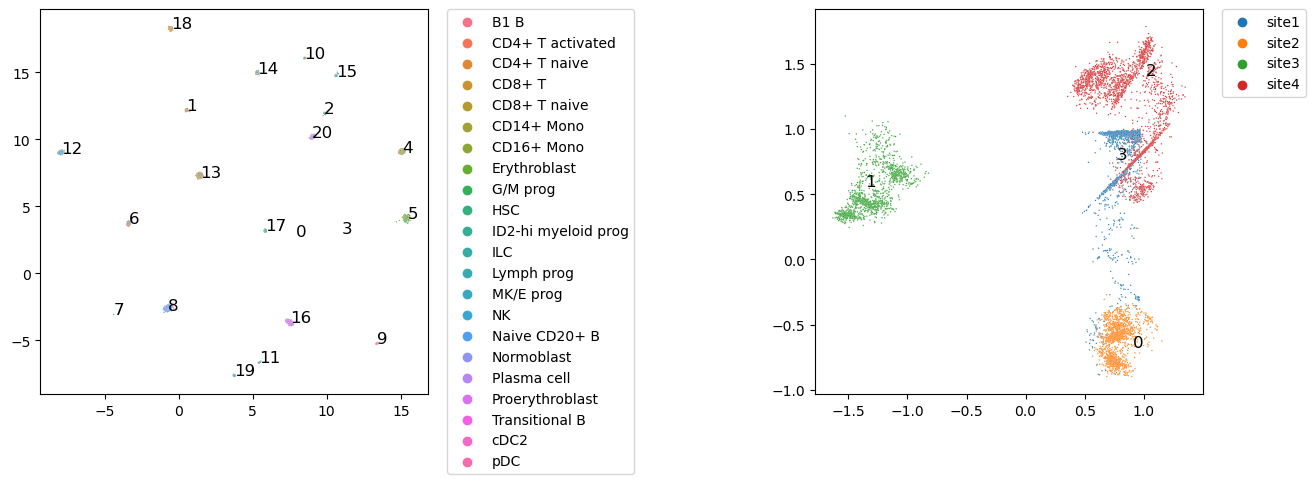

In [5]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### default unsupervised no new components

In [6]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1" + "_test50e_default"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_4612/2007496312.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


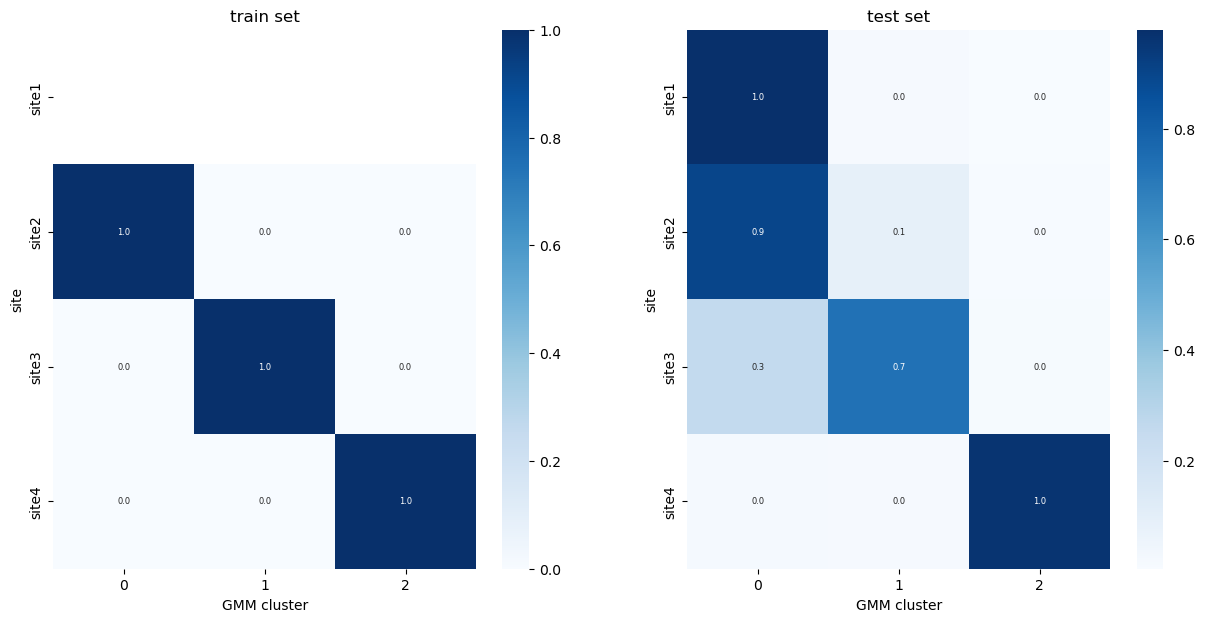

In [7]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

sites = trainset.obs["Site"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["Site"].values == site)[0]
    site_indices_test = np.where(testset.obs["Site"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

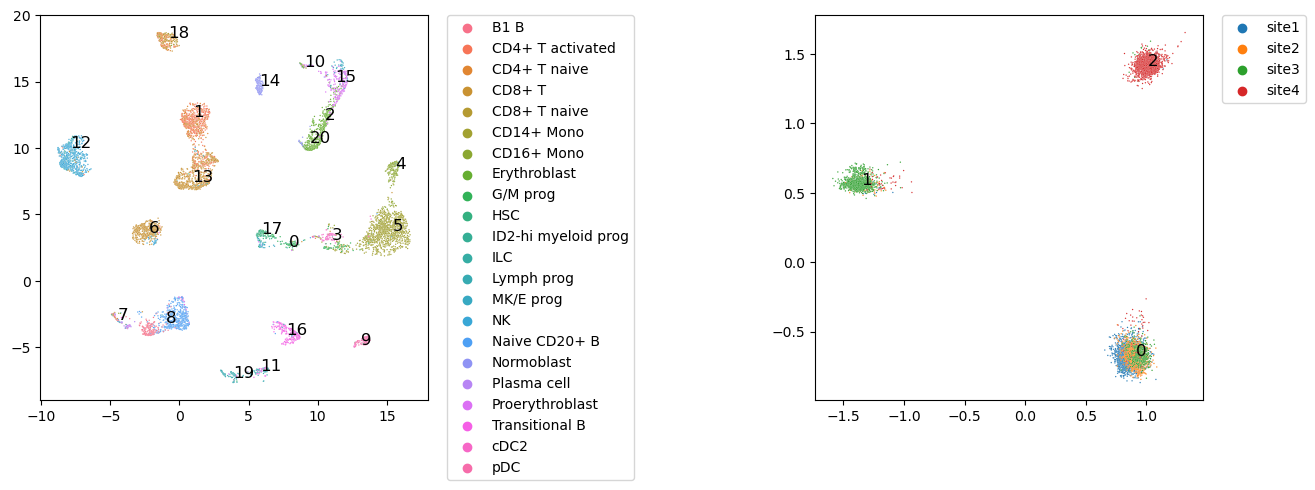

In [8]:
reducer = umap.UMAP()
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### suoervised and beta=5

In [9]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1_test100e_covSupervised_beta1"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


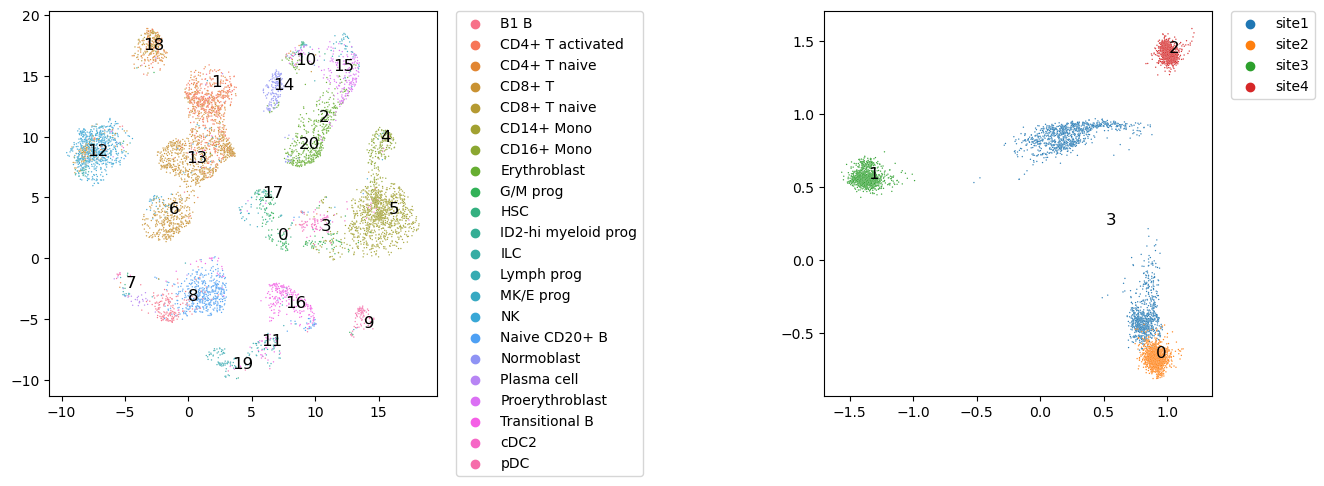

In [10]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1_test100e_covSupervised_beta5"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


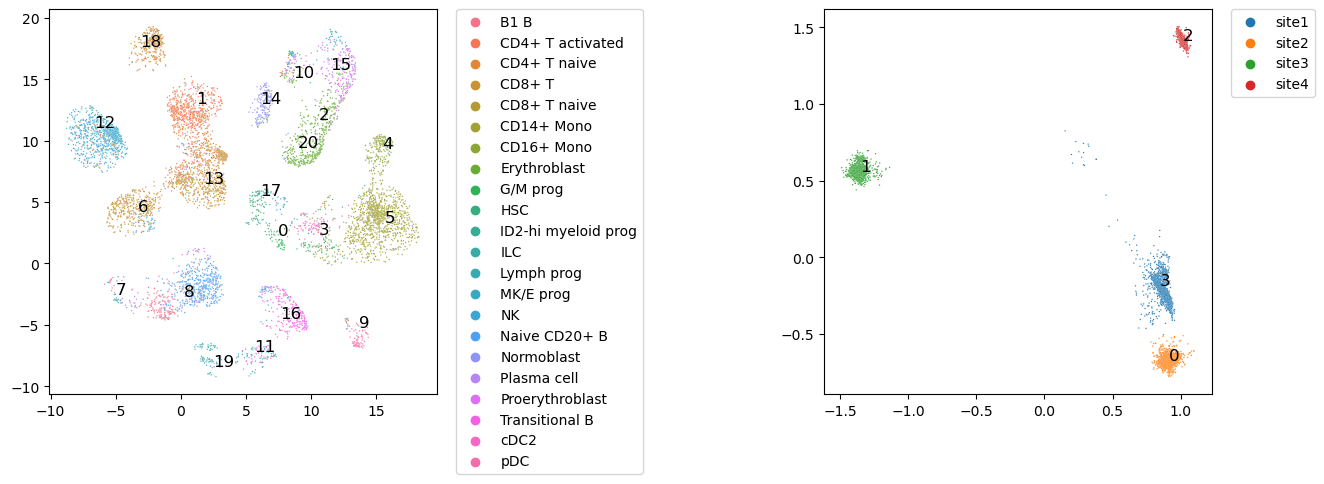

In [4]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [8]:
model = None

In [6]:
i = 0
model_name = "human_bonemarrow_l20_h2-3_leftout_site1_test100e_covSupervised_beta10"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["Site"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 3
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


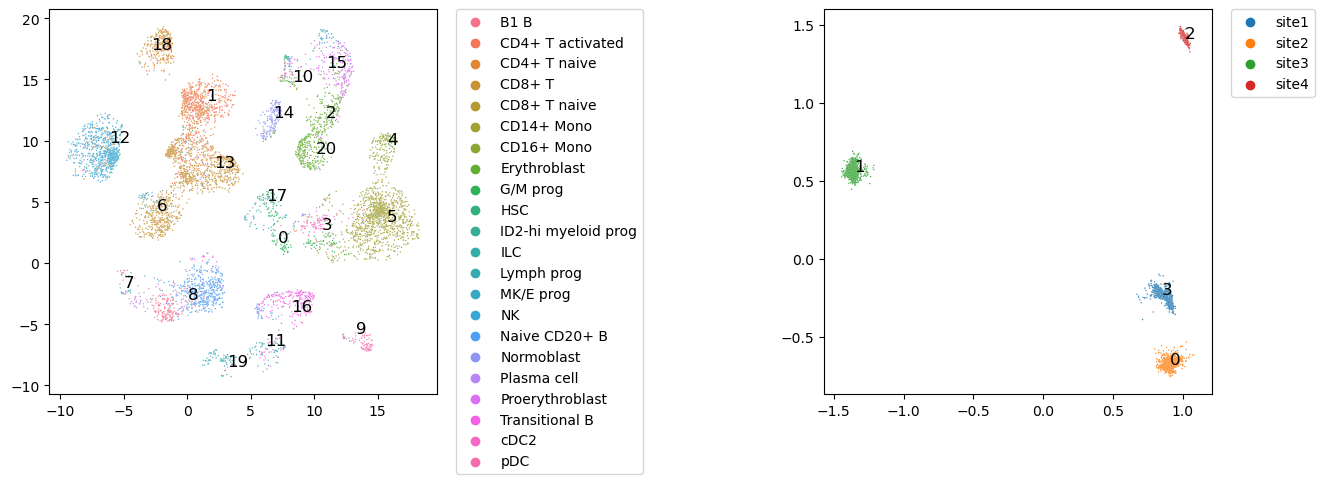

In [7]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
reducer.fit(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["cell_type"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["Site"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()